# Machine vision zebra crossing experiments

- reduce image to just roads
- increase size of test area
- create set of zebra crossing training images; rotate those I have?
- how many pixels does a zebra crossing contain at this 25 cm resolution
- black & white image

In [609]:
import os
import os.path as osp
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import collections
import glob
import pickle
import warnings

import mplleaflet
import matplotlib.pyplot as plt

import folium
import fiona
import pyproj
import shapely as shp
from rasterio._base import gdal_version
import rasterio as rio
#https://rasterio.readthedocs.io/en/latest/
import rasterio.warp
import rasterio.features
from rasterio import plot #essential to plot images in BNG, in correct position, and full RGB 
from rasterio.mask import mask

import cv2 #unable to read jp2, use skimage
import skimage
from skimage import io

import PIL
from PIL import Image

In [675]:

from random import shuffle
from skimage import transform
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import cyvlfeat
import scipy
import sklearn
import timeit
from scipy.spatial.distance import cdist
import time
import itertools
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.cluster import MiniBatchKMeans
import scikitplot as skplt
# Skimage gives us some lossy conversion errors that we really don't care about
# so we suppress them
warnings.filterwarnings('ignore', '', UserWarning)
pd.set_option('display.max_columns', None)

import sys
#print(sys.executable)
print(sys.version)
print(sys.version_info)

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)


In [2]:
%matplotlib inline
pd.set_option('display.max_column', 100) #set max number of cols to display before ...
#check which environment 
print(sys.executable)

/Users/tamsinforbes/anaconda3/bin/python


## Mask non-roads, create 82 tif files showing just roads

- read in each APGB ealing tif file
- convert to greyscale
- mask with ta_rt_ealing_apgb_extent.gpkg roads and tracks polygons covering the total 82 square kilometres (82 tiles)
- save each masked file as new image, using same file name, but in new folder: apgb_ealing82_roads
- 

ta_rt_ealing_apgb_extent 21566
(21566, 23)


<AxesSubplot:>

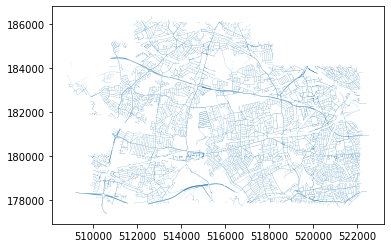

In [3]:
#load ta_rt_ealing_extent

path = "../data/ta_rt_ealing_apgb_extent/ta_rt_ealing_apgb_extent.gpkg"

for layername in fiona.listlayers(path):
    with fiona.open(path, layer=layername) as src:
        print(layername, len(src))
src.close()
#ealing roads gpd
er = gpd.read_file(path, layer = "ta_rt_ealing_apgb_extent")

print(er.shape)

er.plot()

In [4]:
type(er)

geopandas.geodataframe.GeoDataFrame

In [5]:
er.head()

,id,OBJECTID,TOID,FeatureCode,Version,VersionDate,Theme,ThemeCount,CalculatedAreaValue,ChangeDate,ReasonForChange,ChangeHistoryCount,DescriptiveGroup,DescriptiveGroupCount,DescriptiveTerm,DescriptiveTermCount,Make,PhysicalLevel,PhysicalPresence,broken,SHAPE_Length,SHAPE_Area,geometry
0,63019,63019,1000001776530547,10172,4,2003-09-19T00:00:00,Roads Tracks And Paths,1,1534.799016,2003-09-04T00:00:00,Attributes,4,Road Or Track,1,None,NaN,Manmade,50,None,false,438.070928,1534.799000,"POLYGON ((509405.200 183060.500, 509400.670 18..."
1,63066,63066,1000001776552964,10172,1,2001-11-05T00:00:00,Roads Tracks And Paths,1,120.953744,2001-07-12T00:00:00,New,1,Road Or Track,1,None,NaN,Manmade,50,None,false,44.664760,120.953750,"POLYGON ((509415.400 183056.550, 509412.990 18..."
2,63104,63104,1000001776530716,10172,1,2001-11-05T00:00:00,Roads Tracks And Paths,1,199.068472,2000-06-14T00:00:00,New,1,Road Or Track,1,None,NaN,Manmade,50,None,false,83.765029,199.068500,"POLYGON ((509226.450 182995.160, 509222.050 18..."
3,64818,64818,1000001776437278,10172,9,2014-07-03T00:00:00,Roads Tracks And Paths,1,484.336264,2014-07-03T00:00:00,Restructured,7,Road Or Track,1,Track,1.0,Natural,50,None,false,449.433295,484.336039,"POLYGON ((508994.900 184277.600, 509000.000 18..."
4,64846,64846,5000005128162848,10172,3,2019-11-26T00:00:00,Roads Tracks And Paths,1,1059.567493,2019-11-26T00:00:00,Restructured,3,Road Or Track,1,Track,1.0,Natural,50,None,false,570.484635,1059.571366,"POLYGON ((508940.200 183435.700, 508936.950 18..."


In [6]:
#read in a tif file
#set up tif file path names
ealing_tif_paths = glob.glob(
    '../../../ECMM433_Project_1/data/APEaling_111706_20200601/25cm_Aerial_Photo/111706-1_RGB_1_Shape/*.tif'
    , recursive=True)
len(ealing_tif_paths)

82

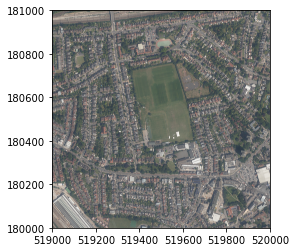

path:  ../../../ECMM433_Project_1/data/APEaling_111706_20200601/25cm_Aerial_Photo/111706-1_RGB_1_Shape/TQ1980.tif 
mode:  r 
is closed?:  True 
band count:  3 
shape:  (4000, 4000) 
transform:  | 0.25, 0.00, 519000.00|
| 0.00,-0.25, 181000.00|
| 0.00, 0.00, 1.00|


In [7]:
with rio.open(ealing_tif_paths[10]) as src:
    rio.plot.show(src.read(), transform=src.transform)

print("path: ", src.name, "\nmode: ", src.mode, "\nis closed?: ", src.closed
      , "\nband count: ", src.count, "\nshape: ", src.shape, "\ntransform: ", src.transform)

In [51]:
for path in ealing_tif_paths:
    src = rio.open(path) #open tif
    save_path = "../data/apgb_ealing82_roads/" + path[-10:]
    
    im, im_trans = mask(
        dataset = src #open raster tif file
        , shapes = er.geometry #shapley polygon geometry column of gdf
        , crop = True #crop to North and East extent of image
        , all_touched = True #include a pixel if it touches any of the shapes
        , nodata = 0 #set nodata value for all RGB layers, 255 = white, 0 = black
        , filled = True              
    ) 
    #set crop/masked image meta data to parent meta data
    im_meta = src.meta
    #update meta data
    im_meta.update(
        {"driver": "GTiff", "height": im.shape[1]
         , "width": im.shape[2], "transform": im_trans})

    #write to tif
    with rasterio.open(save_path, mode = "w", **im_meta) as dest:
        dest.write(im)

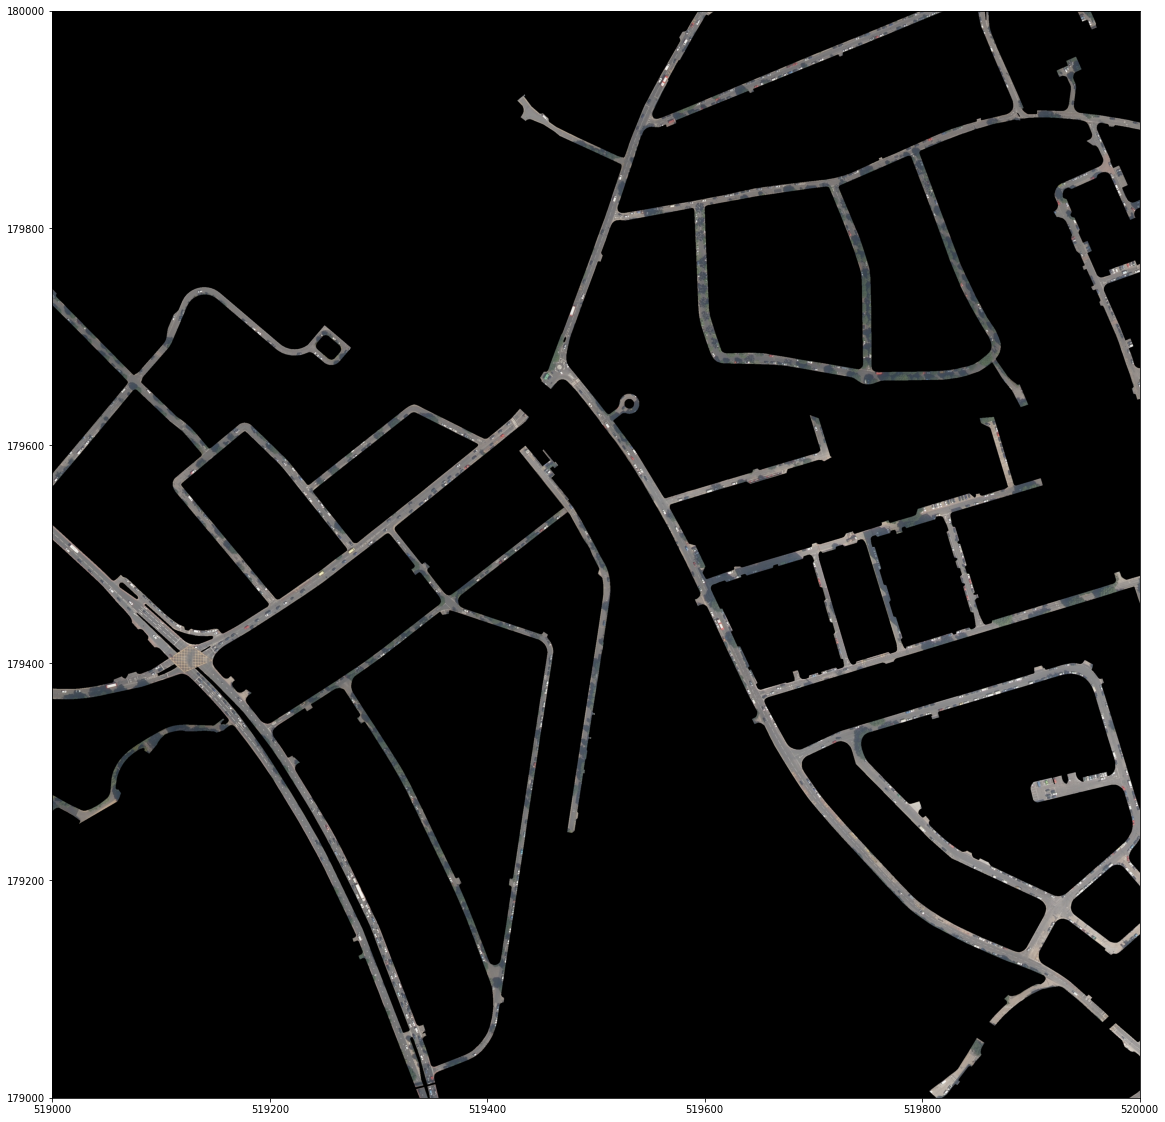

In [8]:
#read in to check
with rio.open("../data/apgb_ealing82_roads/TQ1979.tif") as src:
    fig, ax = plt.subplots(1, figsize=(20, 20))
    rio.plot.show(src.read(), transform=src.transform)

# QGIS manual tag zebra crossings

- In QGIS using the road only image files manually locally zebra crossings
- create shapefile of zebra crossing point location: "../data/zebra_locations_ealing82/zebra_points.shp"
- create shapefile of zebra crossing polygons: "../data/zebra_locations_ealing82/zebra_polygons.shp"
- created geopackage .gpkg versions of each
    - "../data/zebra_locations_ealing82/zebra_polygons.gpkg"
    - "../data/zebra_locations_ealing82/zebra_points.gpkg"

# Jigsaw individual zebra crossing  images

- use zebra_polygons.shp to cut out each individual zebra crossing from its corresponding BNG grid
- read in zebra_polygons.shp, make geodataframe, create field for TQ code from BNG x and y coordinate
- TQ code is 2nd and 3rd digit in BNG coords; eg BNG coordinate (516004, 182357) is in TQ1682.
- some will overlap grids; can I join the grids together first? or just discard these?

In [9]:
#load gpkg version

path = "../data/zebra_locations_ealing82/zebra_polygons.gpkg"

for layername in fiona.listlayers(path):
    with fiona.open(path, layer=layername) as src:
        print(layername, len(src))
src.close()

zp = gpd.read_file(path, layer = "zebra_polygons")
print(zp.shape)

zebra_polygons 369
(369, 2)


<AxesSubplot:>

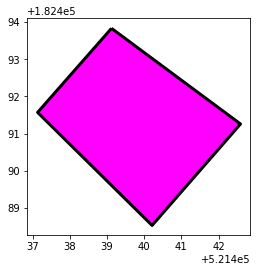

In [10]:
plt.rcParams['figure.figsize'] = (4.0, 4.0)
zp[zp.id == 120].plot(color="magenta", edgecolor="black",linewidth=3)

In [11]:
#add centroid x and y coord and get grid ref
zp["centroid"] = zp.centroid
zp["x"] = zp.centroid.x.apply(str)
zp["y"] = zp.centroid.y.apply(str)
zp["grid"] = "TQ" + zp.x.str[1:3] + zp.y.str[1:3]
#drop unnecessary cols
zp = zp.drop(["x", "y"], axis=1)
zp.head()

,id,geometry,centroid,grid
0,367,"MULTIPOLYGON (((512437.882 185793.856, 512441....",POINT (512441.567 185790.525),TQ1285
1,249,"MULTIPOLYGON (((516677.944 185718.567, 516680....",POINT (516679.813 185717.896),TQ1685
2,250,"MULTIPOLYGON (((516683.339 185720.815, 516686....",POINT (516685.361 185720.226),TQ1685
3,251,"MULTIPOLYGON (((516768.828 185515.308, 516774....",POINT (516772.412 185514.914),TQ1685
4,252,"MULTIPOLYGON (((516736.998 185482.967, 516740....",POINT (516736.473 185477.648),TQ1685


In [12]:
zp_bounds = zp.geometry.bounds
bboxes = []
for idx, r in zp_bounds.iterrows():
    bbox = shp.geometry.Polygon(
        [(r.minx, r.miny), (r.minx, r.maxy), (r.maxx, r.maxy), (r.maxx, r.miny)])
    bboxes.append(bbox)

zp_bounds = zp.copy(deep=True) 
zp_bounds["bbox"] = bboxes
#set geometry to bbox
zp_bounds = zp_bounds.set_geometry("bbox")
print(zp_bounds.geometry.name)
zp_bounds.crs

bbox


<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [13]:
zp_bounds.head()

,id,geometry,centroid,grid,bbox
0,367,"MULTIPOLYGON (((512437.882 185793.856, 512441....",POINT (512441.567 185790.525),TQ1285,"POLYGON ((512437.882 185785.486, 512437.882 18..."
1,249,"MULTIPOLYGON (((516677.944 185718.567, 516680....",POINT (516679.813 185717.896),TQ1685,"POLYGON ((516677.944 185716.077, 516677.944 18..."
2,250,"MULTIPOLYGON (((516683.339 185720.815, 516686....",POINT (516685.361 185720.226),TQ1685,"POLYGON ((516683.339 185718.360, 516683.339 18..."
3,251,"MULTIPOLYGON (((516768.828 185515.308, 516774....",POINT (516772.412 185514.914),TQ1685,"POLYGON ((516768.828 185511.665, 516768.828 18..."
4,252,"MULTIPOLYGON (((516736.998 185482.967, 516740....",POINT (516736.473 185477.648),TQ1685,"POLYGON ((516732.329 185472.208, 516732.329 18..."


In [14]:
grid_list = list(zp.grid.unique())
print(len(grid_list)) #some of the 82 did not contain zebra crossings
#grid_list

72


# Jigsaw zebra crossings

- for each grid that contains zebra crossing
- read in grid tif
- filter zp gdf of zebra polygons to just that grid
- for each row of filtered zp create single row gdf containing one zebra polygon 
- cut out this shape from tif file and save as tif

In [15]:
def jigsaw(raster, gdf, save_path):
    
    #set meta data
    im_meta = raster.meta
    
    for i in np.arange(gdf.shape[0]):
        
        g = gdf.copy(deep=True).iloc[i:i+1] #create single row gdf from gdf of all polygons
        
        #use rasterio.mask.mask from rasterio.mask import mask must be run
        #im: raster np array, im_transform: transform 
        im, im_transform = mask(dataset = raster
                                , shapes = g.geometry #assumes geometry column is named geometry
                                , crop = True #crop to North and East extent of image
                                , all_touched = True #include a pixel if it touches any of the shapes
                                , nodata = 0 #set nodata value for all RGB layers, 255 = white, 0 = black
                                , filled = True 
                               )
        #update meta data
        im_meta.update({"driver": "GTiff"
                        , "height": im.shape[1]
                        ,"width": im.shape[2]
                        ,"transform": im_transform})
        
        #create filename
        filename = save_path + "/" + str(g.grid.iloc[0]) + "_" + str(g.id.iloc[0]) + ".tif"
        
        #write to tif
        with rasterio.open(filename, mode = "w", **im_meta) as dest:
            dest.write(im)

In [45]:
#for path in ealing_tif_paths:
#    src = rio.open(path) #open tif
#    save_path = "../data/apgb_ealing82_roads/" + path[-10:]


In [16]:
zp[zp.grid == "TQ1280"]

,id,geometry,centroid,grid
306,379,"MULTIPOLYGON (((512815.624 180915.922, 512820....",POINT (512817.980 180913.921),TQ1280
307,378,"MULTIPOLYGON (((512813.293 180915.865, 512813....",POINT (512811.742 180914.262),TQ1280
308,380,"MULTIPOLYGON (((512816.621 180681.706, 512823....",POINT (512820.133 180679.808),TQ1280
309,381,"MULTIPOLYGON (((512968.463 180601.657, 512972....",POINT (512970.528 180598.400),TQ1280


In [114]:
#get images of just zebraX
#non zebra space is filled with black pixels, which make for very strong edges
for grid in grid_list:
    path = "../data/apgb_ealing82_roads/" + grid + ".tif"
    #open tif file of just roads
    src = rio.open(path)
    #filter zp for just zebras on this grid
    grid_zp = zp[zp['grid'] == grid]
    #run jigsaw?
    jigsaw(raster=src, gdf=grid_zp, save_path="../data/zebra_individual_apgb") 

In [48]:
#get images of bounding box containing zebraX
#use original grid to avoid any null pixels (filled with black)
root = "../../../ECMM433_Project_1/data/APEaling_111706_20200601/25cm_Aerial_Photo/111706-1_RGB_1_Shape/"
for grid in grid_list:
    path = root + grid + ".tif"
    #open tif file of just roads
    src = rio.open(path)
    #filter zp_bounds for just zebras on this grid
    grid_zp = zp_bounds[zp_bounds['grid'] == grid]
    #run jigsaw?
    jigsaw(raster=src, gdf=grid_zp, save_path="../data/zebra_apgb_bbox") 

# Get grid with most zebras

- TQ2078; but this is half outside my ealing highways layer!!!

In [17]:
#which grid has the most zebras in it
zp_bounds.grid.value_counts()
#TQ2078

TQ2078    22
TQ2183    14
TQ1480    11
TQ2079    11
TQ1982    11
          ..
TQ2180     1
TQ1678     1
TQ1183     1
TQ1182     1
TQ1285     1
Name: grid, Length: 72, dtype: int64

# Zebra polygons data notes
- id 900 to 989 appear to be zebra crossings on private land such as industrial estates, where they tend to mark out pedestrian pathways. These zebras tend to be narrower than standard and sometimes seem to be used instead of pavement, so are aligned to edge and direction of road.
- id 990 to 999 appear to be red and yellow zebras, found on country road, not even sure they are actually striped
- id 100 to 899 mostly standard zebra crossings, though does include some private land ones that are closer to standard. I tagged these before I realised there was an appreciable difference.
- having looked through the images I think some of the private land skinny zebras are usuable
- below is a list of zebra images that are too badly obscured, usually by vehicles or trees, or both

In [18]:
#note id of badly obscured zebra images
obscured_list = [386,384,375,990,991,992,298,302,164,182,132,399,400]

In [19]:
#view some zebra images and look at sizes, detect key points?


In [20]:
#set up tif file path names
zebra_paths = glob.glob(
    '../data/zebra_individual_apgb/*.tif'
    , recursive=True)
zebra_paths = sorted(zebra_paths)
len(zebra_paths)

369

In [21]:
#set up tif file path names
zebra_bbox_paths = glob.glob(
    '../data/zebra_apgb_bbox/*.tif'
    , recursive=True)
zebra_bbox_paths = sorted(zebra_bbox_paths)
len(zebra_bbox_paths)

369

In [22]:
zebra_bbox_paths[0:5]

['../data/zebra_apgb_bbox/TQ1078_396.tif',
 '../data/zebra_apgb_bbox/TQ1078_397.tif',
 '../data/zebra_apgb_bbox/TQ1078_398.tif',
 '../data/zebra_apgb_bbox/TQ1078_957.tif',
 '../data/zebra_apgb_bbox/TQ1078_958.tif']

# get SIFT features

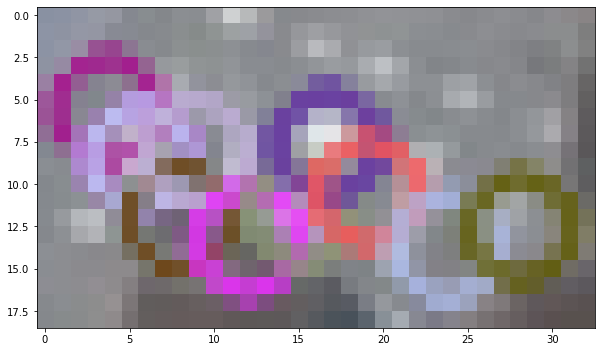

In [27]:
path = zebra_bbox_paths[0]
im = cv2.imread(path)
grey_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(grey_im, None)

kp_im = cv2.drawKeypoints(im, kp, outImage=np.array([]))

#kp_im = cv2.drawKeypoints(im, kp, None, color=(0, 255, 0)
#                          ,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
##DO NOT USE cv2.imshow() it's shit
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(kp_im)

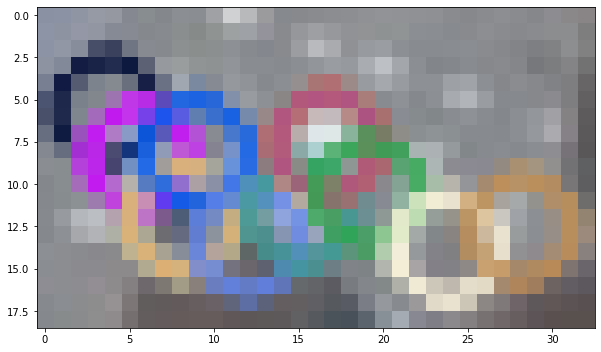

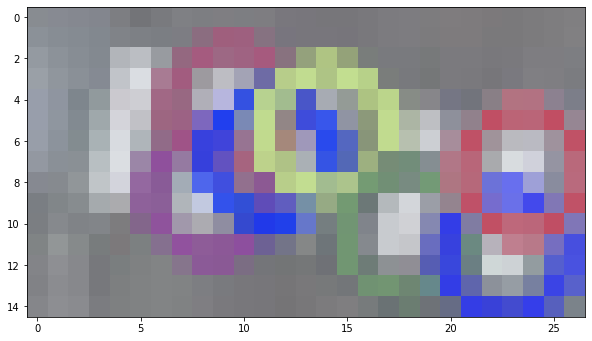

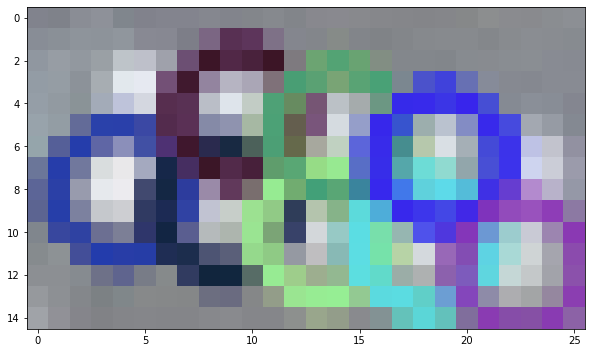

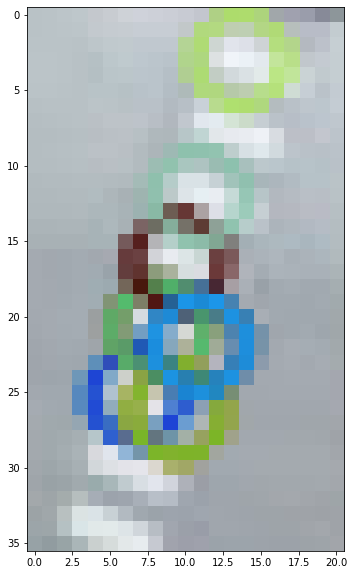

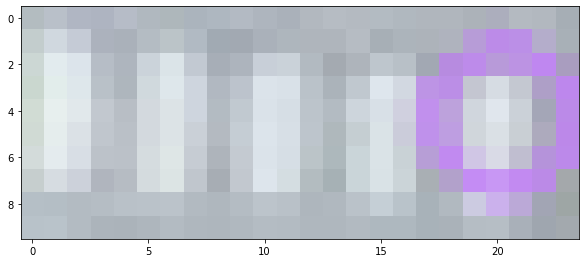

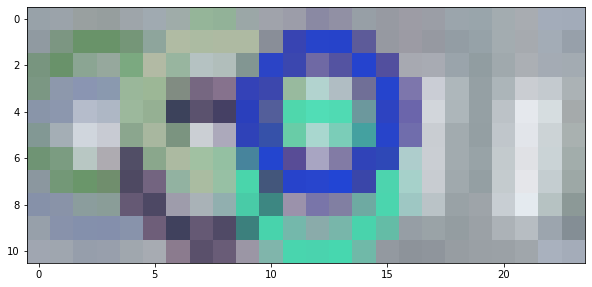

In [31]:
#try on a bunch of images
for path in zebra_bbox_paths[0:6]:
    im = cv2.imread(path)
    grey_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(grey_im, None)
    kp_im = cv2.drawKeypoints(im, kp, outImage=np.array([]))
    plt.rcParams['figure.figsize'] = (10.0, 10.0)
    plt.imshow(kp_im)
    plt.show()

In [33]:
print(des.shape)
des

(9, 128)


array([[ 1.,  0.,  0., ...,  0.,  1.,  0.],
       [ 3.,  1.,  0., ...,  1.,  1.,  2.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 3.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [12.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

# build vocabulary

- use the clean zebra images to collect keypoints from
- only use images that fall outside of the highways layer (hence I can't check them)
- this is the training set (?)
- cluster these to get vocab of representative key zebra features

In [240]:
obscured_list = [386,384,375,990,991,992,298,302,164,182,132,399,400,907]

In [241]:
train_list = [
    131,132,133,400,138,134,178,168,177,176,181,182,180,135,173,172,166,167,170,169,171
    ,174,175,205,207,211,210,212,213,209,208,224,247,248,956,955,952,953,954,950,951
    ,960,961,959,958,957,397,398,396,395,403,394,949,393,376,948,367,249,251,252,250,225
    ,227,215,216,924,214,139,183,184,140,102,100,101,103,104,114,108,110,111,112,113,106,107,109,112
    ,402,141,142,186,187,188,190,191,192,189,217,216,924,227,229,928,929,925,927,926
    ,917,918,919,920,921,922,401,217,906,907,124,126,137,136,179]

print(len(train_list))
#remove dupes by converting to dict and convert back to list
train_list = list( dict.fromkeys(train_list))
len(train_list)
#remove obscured images: train_list - obscured_list
train_list = list( np.setdiff1d(train_list, obscured_list) )
len(train_list)

121


112

## get descriptors from clean zebraX images

In [242]:
zebra_bbox_paths_clean = [p for p in zebra_bbox_paths if not any("_"+str(sub) in p for sub in obscured_list)]

len(zebra_bbox_paths_clean)
print(len(zebra_bbox_paths_clean), len(obscured_list), len(zebra_bbox_paths))
len(zebra_bbox_paths_clean) + len(obscured_list) == len(zebra_bbox_paths)

355 14 369


True

# get descriptor vectors
# USING ALL clean zebra images
descriptors = []
for path in zebra_bbox_paths_clean:
    im = cv2.imread(path)
    grey_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(grey_im, None)
    if des is not None:
        descriptors.append(des)
#concat all descriptors        
descriptors = np.vstack(descriptors)

descriptors.shape

## get descriptors from clean train images only

In [244]:
zebra_bbox_train_paths = [p for p in zebra_bbox_paths if any("_"+str(sub) in p for sub in train_list)]
print(len(train_list))
len(zebra_bbox_train_paths) == len(train_list)

112


True

In [245]:
# get descriptor vectors 
# USING TRAIN ZEBRA IMAGES ONLY
# these images lie outside the highways layer so cannot be used in testing
# I don't I should need many to create the vocab as the zebraX is such a distinct thing
descriptors = []
for path in zebra_bbox_train_paths:
    im = cv2.imread(path)
    grey_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(grey_im, None)
    if des is not None:
        descriptors.append(des)
#concat all descriptors        
descriptors = np.vstack(descriptors)

descriptors.shape

(1569, 128)

## cluster descriptors

Create sets of vocab from the keypoints in the clean training images of zebraX

- all clean images got total of ~5000 descriptors
- training got total of ~1500 descriptors

In [246]:
def build_vocab(des, vocab_size=10, max_iter=300, tol=0.0001):
    kmeans = KMeans(
        n_clusters=vocab_size, max_iter=max_iter, tol=tol, random_state=None).fit(des)
    #collect cluster centres - the representative visual words / vocab
    vocab = kmeans.cluster_centers_
    #save vocab as this stage is time consuimng
    folder = "../data/sift_kmeans/vocab"
    os.makedirs(folder, exist_ok=True)
    filename = ( "vocab_" + str(vocab_size) + ".npy" )
    np.save(os.path.join(folder, filename), vocab)
    print("saved vocab as: ", filename)
    return vocab

In [247]:
for v in [5, 10, 20, 50, 100, 250]:
    build_vocab(descriptors, vocab_size=v)

saved vocab as:  vocab_5.npy
saved vocab as:  vocab_10.npy
saved vocab as:  vocab_20.npy
saved vocab as:  vocab_50.npy
saved vocab as:  vocab_100.npy
saved vocab as:  vocab_250.npy


In [248]:
#set path names
vocab_paths = glob.glob('../data/sift_kmeans/vocab/*.npy', recursive=True)
vocab_paths

['../data/sift_kmeans/vocab/vocab_100.npy',
 '../data/sift_kmeans/vocab/vocab_10.npy',
 '../data/sift_kmeans/vocab/vocab_5.npy',
 '../data/sift_kmeans/vocab/vocab_20.npy',
 '../data/sift_kmeans/vocab/vocab_50.npy',
 '../data/sift_kmeans/vocab/vocab_250.npy']

## get dense sift features

My images are small, may need denser features?

## Create feature histograms

Using the image used for the vocab, use the vocab to create histograms of the frequency of each visual word in the vocab per image. The images used here are clean, mostly completely unobscured and without any further context of the surrounding area. Hence the vocab should be highly specific to the zebra crossing. Hence in any further images we are just looking for zebraX features.

In [249]:
def get_hist_feats(image_paths, vocab_path, batch="x00"
                   , dir_path="sift_kmeans/hist_feats/train"):
    '''
    This function must be used with vocab created with build_vocabulary
    as they both use cv2.SIFT_create to extract keypoints
    
    Inputs:
        image_paths: A Python list of strings, where each string is a complete
                     path to one image on the disk.
        vocab_path: relative path to the vocab array created with build_vocabulary
        batch: batch number to id batches
        dir_path: name of subdirectory to distinguish between 'train' and 'test'

    Outputs:
        An nxd numpy matrix, where n is the number of images in image_paths and
        d is size of the histogram built for each image. Output is saved to 
        given dir_path; folder created if does not exist.
    '''
    #load vocab
    #vocab is nxd array of n words, each vector length d
    vocab = np.load(vocab_path)
    print('Loaded vocab from file:'+ vocab_path)
    vocab_size = vocab.shape[0]
    #init histogram of features list
    hist_feats = []
    for path in image_paths:
        im = cv2.imread(path)
        grey_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        sift = cv2.xfeatures2d.SIFT_create()
        kp, des = sift.detectAndCompute(grey_im, None)
        
        #if no keypoints found append empty row to hist_feats & skip to next image
        if des is None:
            print("No descriptors returned for image at path:\n" + path)
            print("Warning if using in train stage remove this image")
            print("else appending 0 row histogram feature")
            hist_feats.append(np.zeros((1,vocab_size)))
            continue

        ### get dist from vocab words to image descriptors ###
        #output has arg1 rows and arg2 cols
        dist = cdist(des, vocab)
        #sort and get col1 (vocab index of closest word)
        closest = np.argsort(dist)[:,0]
        #unit vectors of hist frqs
        frq, bin_edges = np.histogram(closest, bins=np.arange(0, vocab_size+1))
        norm_frq = frq / np.linalg.norm(frq)
        #append
        hist_feats.append(norm_frq)

    #concat list of arrays into one array
    #all arrays have same number of cols (=vocab_size)
    hist_feats = np.vstack(hist_feats)
    
    #save feats
    os.makedirs(dir_path, exist_ok=True)
    filename = ( batch + "_vocab_size_" + str(vocab_size) + ".npy" )
    np.save(os.path.join(dir_path, filename), hist_feats)
    print("saved features as: ", filename)

    return hist_feats

In [238]:
np.zeros((1,5))

array([[0., 0., 0., 0., 0.]])

In [250]:
#create histogram features for training sets

for vp in vocab_paths:
    get_hist_feats(
        image_paths=zebra_bbox_train_paths
        , vocab_path=vp
        , batch="x00", dir_path="../data/sift_kmeans/hist_feats/train")

Loaded vocab from file:../data/sift_kmeans/vocab/vocab_100.npy
saved features as:  x00_vocab_size_100.npy
Loaded vocab from file:../data/sift_kmeans/vocab/vocab_10.npy
saved features as:  x00_vocab_size_10.npy
Loaded vocab from file:../data/sift_kmeans/vocab/vocab_5.npy
saved features as:  x00_vocab_size_5.npy
Loaded vocab from file:../data/sift_kmeans/vocab/vocab_20.npy
saved features as:  x00_vocab_size_20.npy
Loaded vocab from file:../data/sift_kmeans/vocab/vocab_50.npy
saved features as:  x00_vocab_size_50.npy
Loaded vocab from file:../data/sift_kmeans/vocab/vocab_250.npy
saved features as:  x00_vocab_size_250.npy


# Get images along the road links

- collect an image every 2m along test road links
- use the non-masked image, else will have the problem of the non-road area being black and representing a distinct edge; maybe this won't matter since I used clean images to get the vocab.
- use test short section of road

road_test_set_01_TQ2079 5
(5, 41)


<AxesSubplot:>

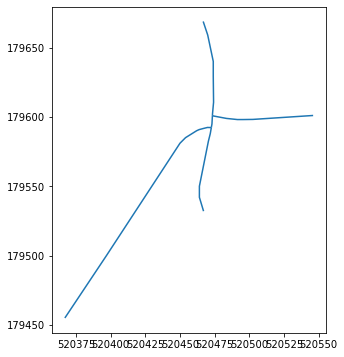

In [209]:
path = "../data/road_tests/road_test_set_01_TQ2079.gpkg"

for layername in fiona.listlayers(path):
    with fiona.open(path, layer=layername) as src:
        print(layername, len(src))
src.close()
#ealing roads gpd
test_roads = gpd.read_file(path, layer = "road_test_set_01_TQ2079")

print(test_roads.shape)
plt.rcParams['figure.figsize'] = (6.0, 6.0)
test_roads.plot()

In [210]:
#drop some fields
tr = test_roads.copy(deep=True)
tr = test_roads[[
    "id", "OBJECTID", "roadClassification", "routeHierarchy", "formOfWay"
    , "roadClassificationNumber", "roadName1_Name", "directionality", "length"
    , "roadWidthMinimum", "roadWidthAverage", "geometry"]]
#cut "m" from roadWidthMinimum and roadWidthAverage
tr["roadWidthMin"] = tr.roadWidthMinimum.str[:-1]
tr["roadWidthAv"] = tr.roadWidthAverage.str[:-1]
#convert to numeric
tr["roadWidthMin"] = pd.to_numeric(tr["roadWidthMin"], errors='coerce')
tr["roadWidthAv"] = pd.to_numeric(tr["roadWidthAv"], errors='coerce')
tr = tr.drop(["roadWidthMinimum", "roadWidthAverage"], axis=1)
tr.dtypes

/Users/tamsinforbes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/tamsinforbes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/tamsinforbes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

id                             int64
OBJECTID                       int64
roadClassification            object
routeHierarchy                object
formOfWay                     object
roadClassificationNumber      object
roadName1_Name                object
directionality                object
length                       float64
geometry                    geometry
roadWidthMin                 float64
roadWidthAv                  float64
dtype: object

In [211]:
tr

,id,OBJECTID,roadClassification,routeHierarchy,formOfWay,roadClassificationNumber,roadName1_Name,directionality,length,geometry,roadWidthMin,roadWidthAv
0,1892,495287,B Road,B Road,Single Carriageway,B490,Acton Lane,bothDirections,8.55,"LINESTRING Z (520472.601 179592.284 9.300, 520...",7.0,9.6
1,3165,879979,B Road,B Road,Single Carriageway,B490,Acton Lane,bothDirections,61.60,"LINESTRING Z (520467.000 179532.000 9.700, 520...",6.2,7.1
2,5569,1478714,B Road,B Road,Single Carriageway,B491,Southfield Road,bothDirections,72.93,"LINESTRING Z (520473.386 179600.788 8.800, 520...",7.4,8.5
3,7471,1975284,Unclassified,Local Road,Single Carriageway,None,Fletcher Road,bothDirections,176.95,"LINESTRING Z (520367.000 179455.000 10.700, 52...",7.1,7.9
4,12337,4869026,B Road,B Road,Single Carriageway,B490,Acton Lane,bothDirections,68.98,"LINESTRING Z (520473.386 179600.788 8.800, 520...",6.1,8.1


In [212]:
print("total length (m):", sum(tr.length) )
print("average min road width (m)", sum(tr.roadWidthMin)/tr.shape[0])
print("average average road width (m)", sum(tr.roadWidthAv)/tr.shape[0])

total length (m): 389.00919938302474
average min road width (m) 6.760000000000001
average average road width (m) 8.24


## interpolate to get points along road links

197


<AxesSubplot:>

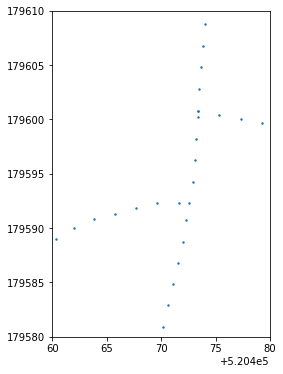

In [213]:
points = []
for i in np.arange(0, tr.shape[0]):
    line = tr.geometry.iloc[i]
    delta = 2.0 #specify a point every metre
    distances = np.arange(0, line.length, delta) #list of distances from start
    points.append([line.interpolate(distance) for distance in distances])

#flatten
points = [item for sublist in points for item in sublist]
#put in df
points_df = gpd.GeoDataFrame({'geometry':points}, crs="EPSG:27700")

print(len(points))
#plt.rcParams['figure.figsize'] = (20.0, 20.0)
#points_df.plot(markersize=0.05)
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(520460, 520480)
ax.set_ylim(179580, 179610)
points_df.plot(ax=ax, markersize=2)

In [214]:
points_df
#these points all have height too!
#use these points to collect images from TQ2079 original 25cm APGB
#keep it simple, use 4m in each direction to create polygon, square even

,geometry
0,POINT Z (520472.601 179592.284 9.300)
1,POINT Z (520472.942 179594.255 9.300)
2,POINT Z (520473.133 179596.243 9.189)
3,POINT Z (520473.244 179598.239 9.018)
4,POINT Z (520473.355 179600.236 8.847)
...,...
192,POINT Z (520469.578 179660.265 8.584)
193,POINT Z (520468.946 179662.163 8.409)
194,POINT Z (520468.313 179664.060 8.235)
195,POINT Z (520467.681 179665.958 8.060)


In [215]:
points_df.geometry.iloc[0].y

179592.28399999999

In [216]:
bboxes = []
for idx, r in points_df.iterrows():
    x = r.geometry.x
    y = r.geometry.y
    d = 4 #4m in each direction arount centre point
    bbox = shp.geometry.Polygon([(x-d,y-d),(x-d,y+d),(x+d,y+d),(x+d,y-d)])
    bboxes.append(bbox)

patches = points_df.copy(deep=True) 
patches["bbox"] = bboxes
#set geometry to bbox
patches = patches.set_geometry("bbox")
print(patches.geometry.name)
patches.crs  

bbox


<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

<AxesSubplot:>

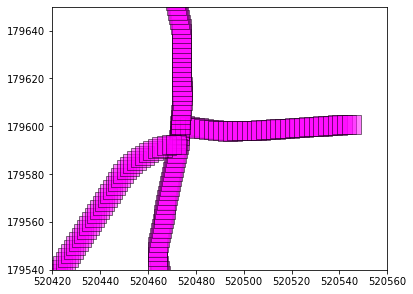

In [217]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(520420, 520560)
ax.set_ylim(179540, 179650)
patches.plot(ax=ax, color="magenta", alpha=0.5, edgecolor="black")

In [218]:
patches.shape[0]

197

In [222]:
#create id and grid col
patches['id'] = np.arange(100, 100+patches.shape[0])
patches['grid'] = "TQ2079"

In [223]:
patches

,geometry,bbox,id,grid
0,POINT Z (520472.601 179592.284 9.300),"POLYGON ((520468.601 179588.284, 520468.601 17...",100,TQ2079
1,POINT Z (520472.942 179594.255 9.300),"POLYGON ((520468.942 179590.255, 520468.942 17...",101,TQ2079
2,POINT Z (520473.133 179596.243 9.189),"POLYGON ((520469.133 179592.243, 520469.133 17...",102,TQ2079
3,POINT Z (520473.244 179598.239 9.018),"POLYGON ((520469.244 179594.239, 520469.244 17...",103,TQ2079
4,POINT Z (520473.355 179600.236 8.847),"POLYGON ((520469.355 179596.236, 520469.355 17...",104,TQ2079
...,...,...,...,...
192,POINT Z (520469.578 179660.265 8.584),"POLYGON ((520465.578 179656.265, 520465.578 17...",292,TQ2079
193,POINT Z (520468.946 179662.163 8.409),"POLYGON ((520464.946 179658.163, 520464.946 17...",293,TQ2079
194,POINT Z (520468.313 179664.060 8.235),"POLYGON ((520464.313 179660.060, 520464.313 17...",294,TQ2079
195,POINT Z (520467.681 179665.958 8.060),"POLYGON ((520463.681 179661.958, 520463.681 17...",295,TQ2079


# Use patches to jigsaw TQ2079 test section


In [230]:
path="../../../ECMM433_Project_1/data/APEaling_111706_20200601/25cm_Aerial_Photo/111706-1_RGB_1_Shape/TQ2079.tif"
src = rio.open(path)
#run jigsaw
jigsaw(raster=src, gdf=patches, save_path="../data/road_patches/set_01_TQ2079") 

In [231]:
#set up tif file path names
road_patch_paths = glob.glob(
    '../data/road_patches/set_01_TQ2079/*.tif'
    , recursive=True)
road_patch_paths = sorted(road_patch_paths)
len(road_patch_paths)

197

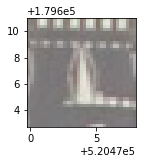

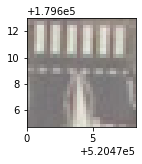

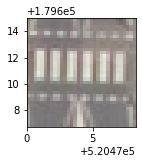

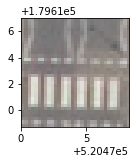

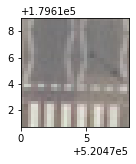

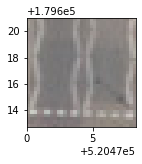

In [261]:
plt.rcParams['figure.figsize'] = (2.0, 2.0)
for path in road_patch_paths[165:171]:
    with rio.open(path) as src:
        rio.plot.show(src.read(), transform=src.transform)

# collect and label patches

- using road test highways roadlink sets
    - interpolate every 2m along each road section to get set of patch midpoints points
    - id by grid ref and number from 1000 to 9999
    - create square polygons from these with same grid ref and id
    - use square polygons to cut out images from original apgb grid, save in road_patches/all_patches named grid_id.tif
- take all_patches and for each grid label if the zebraX polygons for that grid overlap at all

In [262]:
road_set_paths = glob.glob(
    '../data/road_tests/*.gpkg'
    , recursive=True)
road_set_paths = sorted(road_set_paths)
len(road_set_paths)

10

In [278]:
road_set_paths[5:]

['../data/road_tests/road_test_set_TQ1681.gpkg',
 '../data/road_tests/road_test_set_TQ1683.gpkg',
 '../data/road_tests/road_test_set_TQ1781.gpkg',
 '../data/road_tests/road_test_set_TQ2079.gpkg',
 '../data/road_tests/road_test_set_TQ2080.gpkg']

## get patches along roads

Keep getting an error about shape not overlapping raster, tried to fix it, partly successful, but did not grab all images.

In [289]:
for path in road_set_paths[9:]:
    #get grid ref
    grid=path[-11:-5]
    #read tif file
    grid_path=( "../../../ECMM433_Project_1/data/APEaling_111706_20200601/25cm_Aerial_Photo/111706-1_RGB_1_Shape/"
               + grid +".tif")
    src = rio.open(grid_path)
    b = src.bounds
    #read highways layer subset as gdf, use bbox of grid to trim
    roads = gpd.read_file(path, bbox=(b[0],b[1],b[2],b[3]) )
    #ignore road width info for now, collect 8m by 8m patches
    #iterpolate points every 2m along road links
    points = []
    for i in np.arange(0, roads.shape[0]):
        line = roads.geometry.iloc[i]
        delta = 2.0 #specify a point every 2m
        distances = np.arange(0, line.length, delta) #list of distances from start
        points.append([line.interpolate(distance) for distance in distances])

    #flatten
    points = [item for sublist in points for item in sublist]
    #put in df
    points_df = gpd.GeoDataFrame({'geometry':points}, crs="EPSG:27700")
    #create bboxes from points, +-4m from centre point
    bboxes = []
    for idx, r in points_df.iterrows():
        x = r.geometry.x
        y = r.geometry.y
        d = 4 #4m in each direction arount centre point
        bbox = shp.geometry.Polygon([(x-d,y-d),(x-d,y+d),(x+d,y+d),(x+d,y-d)])
        bboxes.append(bbox)
    #create patches df from bboxes, add grid and id cols
    patches = points_df.copy(deep=True) 
    patches["bbox"] = bboxes
    #set geometry to bbox
    patches = patches.set_geometry("bbox")
    #create id and grid col
    patches['id'] = np.arange(1000, 1000+patches.shape[0])
    patches['grid'] = grid
    
    #run jigsaw
    jigsaw(raster=src, gdf=patches
           , save_path="../data/road_patches/all_patches") 

## Label patches

- all_patches in "../data/roiad_patches/all_patches"
- named with grid ref and id number
- read in all patches for a grid, compare to zebra polygons
- append yes/no and info to list to create csv of patch ids and labels

In [307]:
all_patch_paths = glob.glob('../data/road_patches/all_patches/*.tif', recursive=True)
all_patch_paths = sorted(all_patch_paths)
print(len(all_patch_paths))
all_patch_paths[0:4]

2659


['../data/road_patches/all_patches/TQ1280_1000.tif',
 '../data/road_patches/all_patches/TQ1280_1001.tif',
 '../data/road_patches/all_patches/TQ1280_1002.tif',
 '../data/road_patches/all_patches/TQ1280_1003.tif']

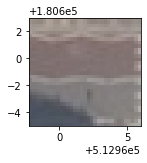

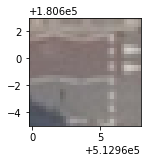

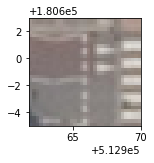

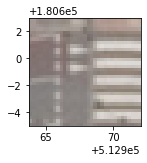

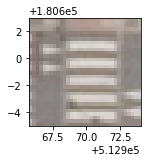

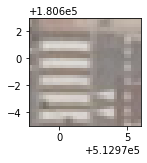

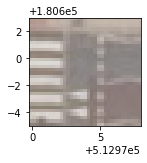

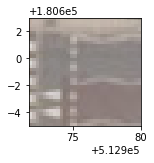

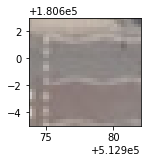

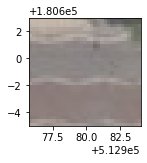

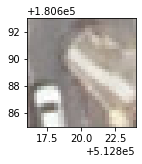

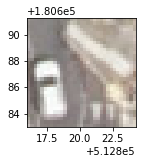

In [292]:
root="../data/road_patches/all_patches/"
grid="TQ1280"
ids=list(np.arange(1029,1041))

for i in ids:
    path = root+grid+"_"+str(i)+".tif"
    with rio.open(path) as src:
        rio.plot.show(src.read(), transform=src.transform)


In [291]:
ids

[1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040]

In [295]:
print(zp.crs, zp.geometry.name)
zp.head()

epsg:27700 geometry


,id,geometry,centroid,grid
0,367,"MULTIPOLYGON (((512437.882 185793.856, 512441....",POINT (512441.567 185790.525),TQ1285
1,249,"MULTIPOLYGON (((516677.944 185718.567, 516680....",POINT (516679.813 185717.896),TQ1685
2,250,"MULTIPOLYGON (((516683.339 185720.815, 516686....",POINT (516685.361 185720.226),TQ1685
3,251,"MULTIPOLYGON (((516768.828 185515.308, 516774....",POINT (516772.412 185514.914),TQ1685
4,252,"MULTIPOLYGON (((516736.998 185482.967, 516740....",POINT (516736.473 185477.648),TQ1685


In [322]:
t1 = root+grid+"_"+str(1031)+".tif"
src = rio.open(t1)
b = src.bounds
#roads = gpd.read_file(path, bbox=(b[0],b[1],b[2],b[3]) )
path = "../data/zebra_locations_ealing82/zebra_polygons.gpkg"
t2 = gpd.read_file(path, layer = "zebra_polygons", bbox=(b[0],b[1],b[2],b[3]))


In [350]:
all_patch_paths[0][-15:-4]

'TQ1280_1000'

In [351]:
#read in each patch, get bounds, read in just the bit of zebra polygon that overlaps the bounds
#I don't think this changes the polygons
zp_path = "../data/zebra_locations_ealing82/zebra_polygons.gpkg"
#init lists
grid_patch = []
grids = []
patch_ids = []
zebra_ids = [] #555 if no zebraX occurs
zebra = [] #1 if some part of zebraX overlaps, 0 otherwise

for p in all_patch_paths:
    src = rio.open(p) #load patch
    b = src.bounds #get bounds
    gp = p[-15:-4]
    grid = p[-15:-9]
    p_id = p[-8:-4]
    #get overlap: olp
    olp = gpd.read_file(zp_path, layer = "zebra_polygons", bbox=(b[0],b[1],b[2],b[3]))
    num_rows=olp.shape[0]
    if num_rows == 0:
        grid_patch.append([gp])
        grids.append([grid])
        patch_ids.append([p_id])
        zebra_ids.append([555])
        zebra.append([0])
    else:
        grid_patch.append(num_rows * [gp])
        grids.append(num_rows * [grid])
        patch_ids.append(num_rows * [p_id])
        zebra_ids.append(list(olp.id))
        zebra.append(num_rows * [1])

        

In [353]:
#put into df and save as csv
#check lengths match
print(len(grid_patch)==len(grids)==len(patch_ids)==len(zebra_ids)==len(zebra))

lists = [grid_patch, grids, patch_ids, zebra_ids, zebra]
for l in lists:
    print(l[0:5])

True
[['TQ1280_1000'], ['TQ1280_1001'], ['TQ1280_1002'], ['TQ1280_1003'], ['TQ1280_1004']]
[['TQ1280'], ['TQ1280'], ['TQ1280'], ['TQ1280'], ['TQ1280']]
[['1000'], ['1001'], ['1002'], ['1003'], ['1004']]
[[555], [555], [555], [555], [555]]
[[0], [0], [0], [0], [0]]


In [354]:
#flatten lists
grid_patch2 = [item for sublist in grid_patch for item in sublist]
print(len(grid_patch2))
grids2 = [item for sublist in grids for item in sublist]
print(len(grids2))
patch_ids2 = [item for sublist in patch_ids for item in sublist]
print(len(patch_ids2))
zebra_ids2 = [item for sublist in zebra_ids for item in sublist]
print(len(zebra_ids2))
zebra2 = [item for sublist in zebra for item in sublist]
print(len(zebra2))

2695
2695
2695
2695
2695


In [363]:
#make df
labels = {'grid_patch':grid_patch2, 'grid':grids2, 'patch_id':patch_ids2, 'zebra_id':zebra_ids2, 'zebra':zebra2}
labels = pd.DataFrame(data=labels)
print(labels.dtypes)
print("number of patches containing zebra or part thereof: ", sum(labels.zebra))
labels.head()

grid_patch    object
grid          object
patch_id      object
zebra_id       int64
zebra          int64
dtype: object
number of patches containing zebra or part thereof:  327


,grid_patch,grid,patch_id,zebra_id,zebra
0,TQ1280_1000,TQ1280,1000,555,0
1,TQ1280_1001,TQ1280,1001,555,0
2,TQ1280_1002,TQ1280,1002,555,0
3,TQ1280_1003,TQ1280,1003,555,0
4,TQ1280_1004,TQ1280,1004,555,0


In [355]:
lists = [grid_patch2, grids2, patch_ids2, zebra_ids2, zebra2]
for l in lists:
    print(l[5:10])

['TQ1280_1005', 'TQ1280_1006', 'TQ1280_1007', 'TQ1280_1008', 'TQ1280_1009']
['TQ1280', 'TQ1280', 'TQ1280', 'TQ1280', 'TQ1280']
['1005', '1006', '1007', '1008', '1009']
[555, 555, 555, 555, 555]
[0, 0, 0, 0, 0]


In [365]:
#save to csv
labels.to_csv("../data/road_patches/all_patches_zebra_labels.csv"
              , header=True, index=False, encoding='utf-8')

# Split data into train and test sets

- split data into train:test 70:30 ratio and within each split equal class sizes
- total 327 patches contain a zebraX or part therof
- train set: 229 patches with zebraX, 229 without 
- test set: 98 patches with zebraX, 98 without

In [385]:
#patches with zebras
z_labels = labels[labels['zebra']==1]
z_train = z_labels.sample(frac=0.7, random_state=123 )
z_test = z_labels[~z_labels.isin(z_train).all(axis=1)]
print(z_train.shape)
print(z_test.shape)

#patches without zebras
nz_labels = labels[labels['zebra']==0].sample(n=327, random_state=123)
nz_train = nz_labels.sample(frac=0.7, random_state=123 )
nz_test = nz_labels[~nz_labels.isin(nz_train).all(axis=1)]
print(nz_train.shape)
print(nz_test.shape)

(229, 5)
(98, 5)
(229, 5)
(98, 5)


In [391]:
z_train

,grid_patch,grid,patch_id,zebra_id,zebra
46,TQ1280_1046,TQ1280,1046,380,1
731,TQ1582_1187,TQ1582,1187,299,1
268,TQ1381_1125,TQ1381,1125,353,1
1163,TQ1781_1138,TQ1781,1138,233,1
1741,TQ2079_1206,TQ2079,1206,159,1
...,...,...,...,...,...
31,TQ1280_1031,TQ1280,1031,381,1
798,TQ1582_1247,TQ1582,1247,298,1
242,TQ1381_1099,TQ1381,1099,355,1
729,TQ1582_1186,TQ1582,1186,299,1


## create train/test image paths and label lists

In [399]:
2*['zx'] + 3*['nzx']

['zx', 'zx', 'nzx', 'nzx', 'nzx']

In [414]:
root="../data/road_patches/all_patches/"
#add to this the grid_patch id and ".tif"
#number of samples in each class is the same
train_class_number = z_train.shape[0]
#order of classes is zx (zebra crossing) then nzx (no zebra crossing)
train_image_paths = list(z_train.grid_patch) + list(nz_train.grid_patch)
train_image_paths = [root + gp + ".tif" for gp in train_image_paths]    
train_labels = train_class_number * ['zx'] + train_class_number * ['nzx']

test_class_number = z_test.shape[0]
test_image_paths = list(z_test.grid_patch) + list(nz_test.grid_patch)
test_image_paths = [root + gp + ".tif" for gp in test_image_paths]    
test_labels = test_class_number * ['zx'] + test_class_number * ['nzx']


print(len(train_labels) == len(train_image_paths) == 2*train_class_number)
len(test_labels) == len(test_image_paths) == 2*test_class_number


True


True

In [412]:
print(train_labels[227:231])
train_image_paths[227:231]

['zx', 'zx', 'nzx', 'nzx']


['../data/road_patches/all_patches/TQ1582_1186.tif',
 '../data/road_patches/all_patches/TQ1381_1094.tif',
 '../data/road_patches/all_patches/TQ1781_1272.tif',
 '../data/road_patches/all_patches/TQ1280_1021.tif']

In [417]:
print(test_labels[96:100])
test_image_paths[96:100]

['zx', 'zx', 'nzx', 'nzx']


['../data/road_patches/all_patches/TQ2080_1919.tif',
 '../data/road_patches/all_patches/TQ2080_1921.tif',
 '../data/road_patches/all_patches/TQ1781_1220.tif',
 '../data/road_patches/all_patches/TQ2080_1739.tif']

# create histogram features for train and test sets

- vocab used has been built from the cleanest set of zebra crossing only images, with no other context. Just the unobscured polygons hugging the edge of the zebra crossing to the stripes (no further part of the crossing)
- I put in a warning that shows if the image generated no key points hence no descriptors, hence zero histogram feature. But I don't think this matters here - think it only matters if this was being used to generate the vocab
- all the images used to generate the vocab produced at least one keypoint. 

In [418]:
vocab_paths

['../data/sift_kmeans/vocab/vocab_100.npy',
 '../data/sift_kmeans/vocab/vocab_10.npy',
 '../data/sift_kmeans/vocab/vocab_5.npy',
 '../data/sift_kmeans/vocab/vocab_20.npy',
 '../data/sift_kmeans/vocab/vocab_50.npy',
 '../data/sift_kmeans/vocab/vocab_250.npy']

In [419]:
batch="x01"
#get train hist feats
for vp in vocab_paths:
    get_hist_feats(
        image_paths=train_image_paths
        , vocab_path=vp
        , batch=batch, dir_path="../data/sift_kmeans/hist_feats/train")
    
#get test hist feats
for vp in vocab_paths:
    get_hist_feats(
        image_paths=test_image_paths
        , vocab_path=vp
        , batch=batch, dir_path="../data/sift_kmeans/hist_feats/test")

Loaded vocab from file:../data/sift_kmeans/vocab/vocab_100.npy
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1683_1000.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ2080_1785.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1681_1186.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1579_1182.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ2080_1225.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for imag

No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1683_1000.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ2080_1785.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1681_1186.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1579_1182.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ2080_1225.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1579_1081.tif
War

No descriptors returned for image at path:
../data/road_patches/all_patches/TQ2080_1225.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1579_1081.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1781_1260.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1781_1118.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ2079_1208.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ2080_1784.tif
War

No descriptors returned for image at path:
../data/road_patches/all_patches/TQ2080_1721.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
saved features as:  x01_vocab_size_5.npy
Loaded vocab from file:../data/sift_kmeans/vocab/vocab_20.npy
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1683_1000.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ2080_1785.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1681_1186.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1579_1182.tif
Warning if using in train stage remove this image
else appending 0 row histogram 

No descriptors returned for image at path:
../data/road_patches/all_patches/TQ2080_1785.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1681_1186.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1579_1182.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ2080_1225.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1579_1081.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1781_1260.tif
War

No descriptors returned for image at path:
../data/road_patches/all_patches/TQ2080_1225.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1579_1081.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1781_1260.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1781_1118.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ2079_1208.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ2080_1784.tif
War

No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1579_1010.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1579_1132.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1683_1000.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1781_1203.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1781_1255.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1781_1258.tif
War

No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1681_1125.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
saved features as:  x01_vocab_size_10.npy
Loaded vocab from file:../data/sift_kmeans/vocab/vocab_5.npy
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1579_1010.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1579_1132.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1683_1000.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1781_1203.tif
Warning if using in train stage remove this image
else appending 0 row histogram 

saved features as:  x01_vocab_size_20.npy
Loaded vocab from file:../data/sift_kmeans/vocab/vocab_50.npy
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1579_1010.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1579_1132.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1683_1000.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1781_1203.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1781_1255.tif
Warning if using in train stage remove this image
else appending 0 row histogram

No descriptors returned for image at path:
../data/road_patches/all_patches/TQ1681_1125.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
saved features as:  x01_vocab_size_250.npy


# Try SVM classifier

In [424]:
def svm_classify(train_image_feats, train_labels, test_image_feats
                , params={}):
    '''
    This function will takes a dictionary of parameters to feed to sklearn.svm.SVC
    and using cross validation searches through these parameters and returns the 
    best scoring set and the labels it predicted.

    Inputs:
        train_image_feats: An nxd numpy array, where n is the number of training
            examples, and d is the image descriptor vector size.
        train_labels: An nx1 Python list containing the corresponding ground
            truth labels for the training data.
        test_image_feats: An mxd numpy array, where m is the number of test
            images and d is the image descriptor vector size.
    Outputs:
        test_preds: An mx1 numpy array of strings, where each string is the 
            predicted label for the corresponding image in test_image_feats 
        clf.best_params: the best parameters found by GridSearchCV for the 
            features provided
    '''
    
    #set up model with fixed params
    svm = SVC(probability=True)

    clf = GridSearchCV(
        estimator = svm
        , param_grid = params
        , n_jobs = -1 #use all available cores!
        , cv = 5
        , return_train_score = True)
    #train and validate model
    clf.fit(train_image_feats, train_labels)
    
    #get prediction string list using best model
    test_preds = clf.predict(test_image_feats)
    
    return test_preds, clf.best_params_

In [430]:
train_labels[-5:]

['nzx', 'nzx', 'nzx', 'nzx', 'nzx']

In [636]:
np.logspace(-1, 2, num = 4, base = 10)


array([  0.1,   1. ,  10. , 100. ])

In [736]:
###set up param lists 
C_range = np.logspace(-1, 2, num = 4, base = 10)  #default is 1, C>0
gamma_range = np.logspace(-2, 1, num = 4, base = 10)  #default is 0.1
kernel_list = list(['linear', 'rbf', 'poly', 'sigmoid'])
poly_degree_range = np.arange(2, 5, 1) #default is 3, ignored by other kernels
#set up params dict
params = {'C' : list(C_range), 'gamma' : list(gamma_range), 'kernel': kernel_list
          , 'degree' : list(poly_degree_range)}


In [737]:
params

{'C': [0.1, 1.0, 10.0, 100.0],
 'gamma': [0.01, 0.1, 1.0, 10.0],
 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
 'degree': [2, 3, 4]}

|parameter|set of values|
|:---|:---|
|C|[0.1, 1.0, 10.0, 100.0]|
|gamma|[0.01, 0.1, 1.0, 10.0]|
|kernel|['linear', 'rbf', 'poly', 'sigmoid']|
|degree|[2, 3, 4]|

In [431]:
#try batch 01
###get paths to features
batch='x01'
root_dir="../data/sift_kmeans/"

#collect all names from test folder as there may be some odds in train folder
feature_filenames = np.sort( os.listdir(os.path.join(root_dir, "hist_feats/test/")) )
#subset to just those I want
feature_filenames = list(filter(lambda f: f.startswith(batch), feature_filenames))
#create lists of full paths to train & test features
train_feat_paths = [root_dir +"/hist_feats/train/" + f for f in feature_filenames]
test_feat_paths = [root_dir + "/hist_feats/test/" + f for f in feature_filenames]

###set up param lists 
C_range = np.logspace(-1, 2, num = 4, base = 10)  #default is 1, C>0
gamma_range = np.logspace(-2, 1, num = 4, base = 10)  #default is 0.1
kernel_list = list(['linear', 'rbf', 'poly', 'sigmoid'])
poly_degree_range = np.arange(2, 5, 1) #default is 3, ignored by other kernels
#set up params dict
params = {'C' : list(C_range), 'gamma' : list(gamma_range), 'kernel': kernel_list
          , 'degree' : list(poly_degree_range)}
print("params grid: ", params)

#### start loop
best_preds = []
best_params = []
best_scores = []

cnt=1

for train_path, test_path in zip(train_feat_paths, test_feat_paths):
    print('job count:', str(cnt))
    #load precomputed train & test features
    train_image_feats = np.load(train_path)
    test_image_feats = np.load(test_path)
    #for each feature set get best svm score
    test_pred, best_param = svm_classify(
        train_image_feats, train_labels, test_image_feats, params=params)
    #append results
    best_preds.append(test_pred.tolist())
    best_params.append(best_param)
    best_scores.append( sum(test_pred == test_labels)/len(test_labels) )
    #update job count
    cnt += 1

#### end loop

#output df of feature filename, best k score and best k
data = {'feature_filename' : feature_filenames, 'best_svm_score' :best_scores
       , 'best_params' : best_params, 'best_prediction':best_preds}
bovw_svm_scores = pd.DataFrame(data = data)

#save
fpath = "../data/sift_kmeans/results/" + batch + "_bovw_svm_scores.csv"
bovw_svm_scores.to_csv(fpath, index=False, header=True)

params grid:  {'C': [0.1, 1.0, 10.0, 100.0], 'gamma': [0.01, 0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'degree': [2, 3, 4]}
job count: 1
job count: 2
job count: 3
job count: 4
job count: 5
job count: 6


In [735]:
params

{'C': [[1.0]], 'gamma': [1.0], 'kernel': ['poly'], 'degree': [3]}

In [738]:
best_params

[{'C': 1.0, 'degree': 3, 'gamma': 1.0, 'kernel': 'poly'},
 {'C': 1.0, 'degree': 3, 'gamma': 1.0, 'kernel': 'poly'},
 {'C': 10.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'},
 {'C': 10.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'},
 {'C': 1.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'},
 {'C': 10.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}]

In [432]:
bovw_svm_scores

,feature_filename,best_svm_score,best_params,best_prediction
0,x01_vocab_size_10.npy,0.780612,"{'C': 1.0, 'degree': 3, 'gamma': 1.0, 'kernel'...","[zx, zx, zx, zx, zx, zx, zx, zx, zx, zx, nzx, ..."
1,x01_vocab_size_100.npy,0.821429,"{'C': 1.0, 'degree': 3, 'gamma': 1.0, 'kernel'...","[zx, zx, zx, zx, zx, zx, zx, zx, zx, zx, zx, z..."
2,x01_vocab_size_20.npy,0.770408,"{'C': 10.0, 'degree': 2, 'gamma': 0.1, 'kernel...","[zx, zx, zx, zx, zx, zx, zx, zx, zx, zx, nzx, ..."
3,x01_vocab_size_250.npy,0.806122,"{'C': 10.0, 'degree': 2, 'gamma': 1.0, 'kernel...","[zx, zx, zx, zx, zx, zx, zx, zx, zx, zx, nzx, ..."
4,x01_vocab_size_5.npy,0.780612,"{'C': 1.0, 'degree': 2, 'gamma': 1.0, 'kernel'...","[zx, zx, zx, zx, zx, zx, zx, zx, zx, zx, nzx, ..."
5,x01_vocab_size_50.npy,0.790816,"{'C': 10.0, 'degree': 2, 'gamma': 1.0, 'kernel...","[zx, zx, zx, zx, zx, zx, zx, zx, zx, zx, zx, z..."


# Show results

- confusion matrix, maybe try website builder thing ? 
- this will nicely show the TP/TN/FP/FN combinations can see which ones it got right/wrong and speculate why.

Compute confusion matrix to evaluate the accuracy of a classification.
- By definition a confusion matrix $C$ is such that $C_{i,j}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$.
- Thus in binary classification, the count of true negatives is $C_{0,0}$, false negatives is $C_{1,0}$, true positives is $C_{1,1}$ and false positives is $C_{0,1}$.

In [452]:
# Show results
def show_results(train_labels, test_labels,categories, abbr_categories, predicted_categories):
    """
    shows the results
    :param train_image_paths:
    :param test_image_paths:
    :param train_labels:
    :param test_labels:
    :param categories:
    :param abbr_categories:
    :param predicted_categories:
    :return:
    """
    cat2idx = {cat: idx for idx, cat in enumerate(categories)}

    # confusion matrix
    y_true = [cat2idx[cat] for cat in test_labels]
    y_pred = [cat2idx[cat] for cat in predicted_categories]
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype(np.float64) / cm.sum(axis=1)[:, np.newaxis]
    acc = np.mean(np.diag(cm))
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('spring'))
    plt.title('Confusion matrix. Mean of diagonal = {:4.2f}%'.format(acc*100))
    tick_marks = np.arange(len(categories))
    plt.tight_layout()
    plt.xticks(tick_marks, abbr_categories, rotation=45)
    plt.yticks(tick_marks, categories)

In [453]:
categories = ['zebra crossing', 'no zebra crossing']
abbr_categories = ['zx', 'nzx']

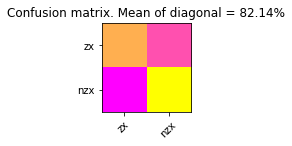

In [454]:
best_pred = bovw_svm_scores.best_prediction[1]
show_results(
    train_labels, test_labels, abbr_categories, abbr_categories, best_pred
)

I'm taking zebra crossing (ZX) as "positive" outcome and no zebra crossing (NZX) as "negative" outcome. Hence,

- True Positive (TP): predicted ZX and is ZX (correctly predicts ZX)
- False Positive (FP): predicted ZX but is NZX (incorrectly predicts ZX)
- True Negative (TN): predicted NZX and is NZX (correctly predicts NZX)
- False Negative (FN): predicted NZX but is ZX (incorrectly predicts NZX)

In [445]:
cat2idx = {cat: idx for idx, cat in enumerate(abbr_categories)}
# confusion matrix
y_true = [cat2idx[cat] for cat in test_labels]
y_pred = [cat2idx[cat] for cat in best_pred]
cm = confusion_matrix(y_true, y_pred)
cm

array([[66, 32],
       [ 3, 95]])

||predicted: zebra crossing|predicted: no zebra crossing|total
|:---|:---:|:---:|---:|
|actual: zebra crossing|66 TP|32 FN|98|
|actual: no zebra crossing|3 FP|95 TN|98|
|total|69|127|196|

### Score (accuracy), Precision, Recall and MCC
- Score (accuracy) is the simple proportion correctly predicted $S = \frac{tp+tn}{tp+fn+fp+tn}$
- https://en.wikipedia.org/wiki/Precision_and_recall#:~:text=Recall%20is%20the%20number%20of,documents%20retrieved%20by%20that%20search.
- Precision $P = \frac{tp}{tp + fp}$
- Recall $R = \frac{tp}{tp+fn}$
- MCC (Matthews correlation coefficient) or phi coefficient is a metric to compare precision and recall scores 
    - https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    - good for binary classification task
    - goes from -1 to +1 where +1 is perfect prediction, 0 no better than random, and -1 indicates total disagreement between prediction and observation.
    - $MCC = \frac{TP \times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$


Best model:
- Score (accuracy): $\frac{66+95}{196} = 0.83$; hence, $82\%$ of images were correctly classed (as either with or without a zebra crossing)
- Precision: $P = \frac{66}{66+3} = 0.96$; hence, $97\%$ of images predicted as containing a zebra crossing did actually contain a zebra crossing.
- Recall: $R = \frac{66}{66+32} = 0.67$; hence, this model found (recalled) $67\%$ of all the images that actually contained a zebra crossing.
- MCC: $\frac{66\times 95 - 3 \times 32}{\sqrt{(66+3)(66+32)(95+3)(95+32)}} = \frac{6174}{\sqrt{84159852}} = \frac{6174}{9174}=0.672989$

In [491]:
pd.set_option('display.max_colwidth', 25) #col_width is number of characters per col
#bbss (best bovw svm scores): add more columns to bovw_svm_scores
bbss = bovw_svm_scores.copy(deep=True)
bbss["vocab_size"] = [10, 100, 20, 250, 5, 50]
bbss = bbss.sort_values(by=["vocab_size"]) #sort to order by vocab size
bbss = bbss.reset_index(drop=True) #reset index and drop old one
# get cm arrays for each vocab best model
cm_arrays=[]
for pred in bbss.best_prediction:
    cat2idx = {cat: idx for idx, cat in enumerate(abbr_categories)}
    # confusion matrix
    y_true = [cat2idx[cat] for cat in test_labels]
    y_pred = [cat2idx[cat] for cat in pred]
    cm_arrays.append(confusion_matrix(y_true, y_pred))
#add to df
bbss["cm_array"] = cm_arrays
# get TP, TN, FP, FN each vocab best model
tp=[]
fn=[]
fp=[]
tn=[]
for cm in bbss.cm_array:
    tp.append(cm[0][0])
    fn.append(cm[0][1])
    fp.append(cm[1][0])
    tn.append(cm[1][1])
#add to df
bbss["tp"] = tp
bbss["fn"] = fn
bbss["fp"] = fp
bbss["tn"] = tn

# get precision, recall and mcc
precision=[]
recall=[]
mcc=[]
for cm in bbss.cm_array:
    tp=cm[0][0]
    fn=cm[0][1]
    fp=cm[1][0]
    tn=cm[1][1]
    precision.append(tp/(tp+fp))
    recall.append(tp/(tp+fn))
    mcc.append( ( (tp*tn)-(fp*fn) )/np.sqrt( (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn) ) )
#add to df
bbss["precision"] = precision
bbss["recall"] = recall
bbss["mcc"] = mcc
    
bbss

,feature_filename,best_svm_score,best_params,best_prediction,vocab_size,cm_array,tp,fn,fp,tn,precision,recall,mcc
0,x01_vocab_size_5.npy,0.780612,"{'C': 1.0, 'degree': ...","[zx, zx, zx, zx, zx, ...",5,"[[61, 37], [6, 92]]",61,37,6,92,0.910448,0.622449,0.591603
1,x01_vocab_size_10.npy,0.780612,"{'C': 1.0, 'degree': ...","[zx, zx, zx, zx, zx, ...",10,"[[60, 38], [5, 93]]",60,38,5,93,0.923077,0.612245,0.596033
2,x01_vocab_size_20.npy,0.770408,"{'C': 10.0, 'degree':...","[zx, zx, zx, zx, zx, ...",20,"[[62, 36], [9, 89]]",62,36,9,89,0.873239,0.632653,0.562590
3,x01_vocab_size_50.npy,0.790816,"{'C': 10.0, 'degree':...","[zx, zx, zx, zx, zx, ...",50,"[[69, 29], [12, 86]]",69,29,12,86,0.851852,0.704082,0.590586
4,x01_vocab_size_100.npy,0.821429,"{'C': 1.0, 'degree': ...","[zx, zx, zx, zx, zx, ...",100,"[[66, 32], [3, 95]]",66,32,3,95,0.956522,0.673469,0.672999
5,x01_vocab_size_250.npy,0.806122,"{'C': 10.0, 'degree':...","[zx, zx, zx, zx, zx, ...",250,"[[69, 29], [9, 89]]",69,29,9,89,0.884615,0.704082,0.625407


In [492]:
pd.set_option('display.max_colwidth', None)
print(bbss.best_params.to_string())

0     {'C': 1.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}
1    {'C': 1.0, 'degree': 3, 'gamma': 1.0, 'kernel': 'poly'}
2    {'C': 10.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
3    {'C': 10.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}
4    {'C': 1.0, 'degree': 3, 'gamma': 1.0, 'kernel': 'poly'}
5    {'C': 10.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}


## Tables

In [740]:
bbss[["vocab_size", "best_params", "best_svm_score", ]]

,vocab_size,best_params,best_svm_score
0,5,"{'C': 1.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}",0.780612
1,10,"{'C': 1.0, 'degree': 3, 'gamma': 1.0, 'kernel': 'poly'}",0.780612
2,20,"{'C': 10.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}",0.770408
3,50,"{'C': 10.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}",0.790816
4,100,"{'C': 1.0, 'degree': 3, 'gamma': 1.0, 'kernel': 'poly'}",0.821429
5,250,"{'C': 10.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}",0.806122


In [746]:
tab1 = bbss.copy(deep=True)
tab1 = tab1[["vocab_size", "best_svm_score","tp","fn","fp","tn" ]]
tab1["tp"] = tab1 ["tp"]/98
tab1["fn"] = tab1 ["fn"]/98
tab1["fp"] = tab1 ["fp"]/98
tab1["tn"] = tab1 ["tn"]/98
tab1

,vocab_size,best_svm_score,tp,fn,fp,tn
0,5,0.780612,0.622449,0.377551,0.061224,0.938776
1,10,0.780612,0.612245,0.387755,0.051020,0.948980
2,20,0.770408,0.632653,0.367347,0.091837,0.908163
3,50,0.790816,0.704082,0.295918,0.122449,0.877551
4,100,0.821429,0.673469,0.326531,0.030612,0.969388
5,250,0.806122,0.704082,0.295918,0.091837,0.908163


## sensitivity and specificity

- sensitivity = true positive rate = tp/(tp+fn), ie the correctly identified positives out of all the actual positives.
- specificity = true negative rate = tn/(tn+fp), ie the correctly identified negatives out of all the actual negatives.

In [757]:
tab2 = bbss.copy(deep=True)
tab2 = tab2[["vocab_size", "best_svm_score","tp","tn","precision","recall","mcc" ]]
tab2["sensitivity"] = tab2 ["tp"]/98
tab2["specificity"] = tab2 ["tn"]/98
tab2=tab2[["vocab_size", "best_svm_score","sensitivity","specificity","precision","recall","mcc" ]]
tab2=tab2.rename(columns={"best_svm_score":"accuracy"})
tab2 = tab2[["vocab_size", "accuracy","recall","specificity","precision","mcc" ]]
tab2

,vocab_size,accuracy,recall,specificity,precision,mcc
0,5,0.780612,0.622449,0.938776,0.910448,0.591603
1,10,0.780612,0.612245,0.948980,0.923077,0.596033
2,20,0.770408,0.632653,0.908163,0.873239,0.562590
3,50,0.790816,0.704082,0.877551,0.851852,0.590586
4,100,0.821429,0.673469,0.969388,0.956522,0.672999
5,250,0.806122,0.704082,0.908163,0.884615,0.625407


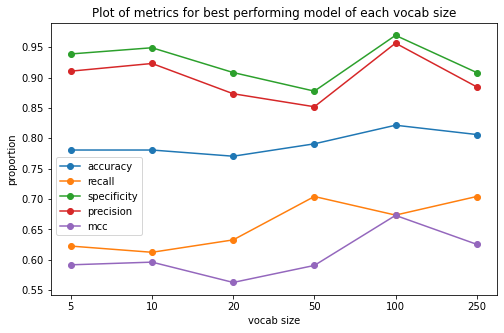

In [761]:
#plot of tab2
#plt.rcParams['figure.figsize'] = (8.0, 5.0)

cols = ["accuracy", "recall", "specificity", "precision", "mcc" ]
fig, ax = plt.subplots(figsize=(8.0, 5.0))
for c in cols:
    ax.plot(tab2.vocab_size.astype(str), tab2[c], label=c, marker='o')
    ax.legend(loc="lower left", bbox_to_anchor=(0,0.20,0,0))#loc and bbox are linked
ax.set_xlabel("vocab size")
ax.set_ylabel("proportion")
plt.title("Plot of metrics for best performing model of each vocab size")
plt.show()

In [755]:
tab3 = bbss.copy(deep=True)
tab3 = tab3[["vocab_size", "best_params", "best_svm_score" ]]
tab3 = tab3.rename(columns={"best_svm_score":"accuracy"})
tab3

,vocab_size,best_params,accuracy
0,5,"{'C': 1.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}",0.780612
1,10,"{'C': 1.0, 'degree': 3, 'gamma': 1.0, 'kernel': 'poly'}",0.780612
2,20,"{'C': 10.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}",0.770408
3,50,"{'C': 10.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}",0.790816
4,100,"{'C': 1.0, 'degree': 3, 'gamma': 1.0, 'kernel': 'poly'}",0.821429
5,250,"{'C': 10.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}",0.806122


## Plot score (accuracy), precision, recall and mcc

- For the best model of each vocab size plot accuracy, precision, recall and mcc
- can also compare the rbf and poly models hyperparams

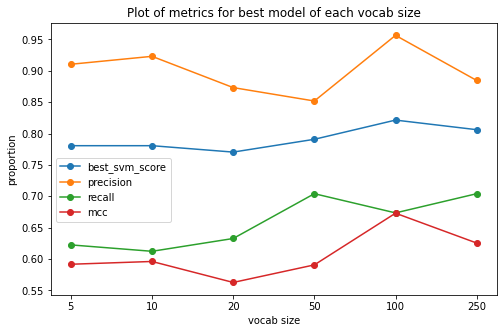

In [539]:
#plt.rcParams['figure.figsize'] = (8.0, 5.0)

cols = ["best_svm_score","precision", "recall", "mcc" ]
fig, ax = plt.subplots(figsize=(8.0, 5.0))
for c in cols:
    ax.plot(bbss.vocab_size.astype(str), bbss[c], label=c, marker='o')
    ax.legend(loc="lower left", bbox_to_anchor=(0,0.25,0,0))#loc and bbox are linked
ax.set_xlabel("vocab size")
ax.set_ylabel("proportion")
plt.title("Plot of metrics for best model of each vocab size")
plt.show()

# ROC curve ??? 

Do I need this? - yes

An ROC curve shows the relationship between clinical sensitivity and specificity for every possible cut-off. The ROC curve is a graph with: The x-axis showing 1 – specificity (= false positive fraction = FP/(FP+TN)) The y-axis showing sensitivity (= true positive fraction = TP/(TP+FN))

In [632]:
print(bbss.feature_filename[4])
bbss.best_params[4]

x01_vocab_size_100.npy


{'C': 1.0, 'degree': 3, 'gamma': 1.0, 'kernel': 'poly'}

In [653]:
#rerun best scoring model and get probabilities per obs classification decision
#this is using 100 vocab, which is index 1 in paths lists
train_image_feats = np.load(train_feat_paths[1])
test_image_feats = np.load(test_feat_paths[1])

svm=SVC(C=1.0, kernel='poly', degree=3, gamma=1.0, probability=True)
cv_clf = GridSearchCV(
    estimator = svm
    , param_grid={'C': [1.0], 'kernel':['poly'], 'degree':[3], 'gamma':[1.0]}
    , n_jobs = -1 #use all available cores!
    , cv = 5
    , return_train_score = True)
#train and validate model
cv_clf.fit(train_image_feats, train_labels)


GridSearchCV(cv=5, estimator=SVC(gamma=1.0, kernel='poly', probability=True),
             n_jobs=-1,
             param_grid={'C': [1.0], 'degree': [3], 'gamma': [1.0],
                         'kernel': ['poly']},
             return_train_score=True)

In [654]:
#cv_clf.predict(test_image_feats)
#cv_clf.best_params_
cv_clf.cv_results_

{'mean_fit_time': array([0.15548086]),
 'std_fit_time': array([0.0443528]),
 'mean_score_time': array([0.00529952]),
 'std_score_time': array([0.0017727]),
 'param_C': masked_array(data=[1.0],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_degree': masked_array(data=[3],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[1.0],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['poly'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1.0, 'degree': 3, 'gamma': 1.0, 'kernel': 'poly'}],
 'split0_test_score': array([0.82608696]),
 'split1_test_score': array([0.83695652]),
 'split2_test_score': array([0.83695652]),
 'split3_test_score': array([0.76923077]),
 'split4_test_score': array([0.79120879]),
 'mean_test_score': array([0.81208791]),
 'std_test_score': array([0.0272233

In [762]:
len(train_image_paths)

458

In [763]:
len(test_image_paths)

196

# SVM with best params and vocab and ROC/AUC scores

- https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- fit SVM best model with best vocab
- get probabilities for each observation for each class
- now can plot ROC curve of fpr against tpr

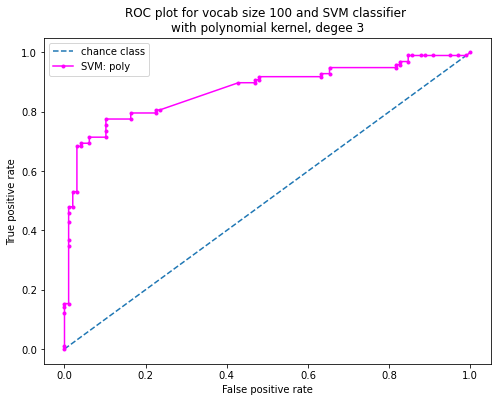

In [683]:
#just run SVM with those paramas, onces, no CV to get probabilities!
#this is using 100 vocab, which is index 1 in paths lists
train_image_feats = np.load(train_feat_paths[1])
test_image_feats = np.load(test_feat_paths[1])
clf = SVC(C=1.0, kernel='poly', degree=3, gamma=1.0, probability=True)
clf.fit(train_image_feats, train_labels)
clf.predict(test_image_feats)[0:5]

#this returns an array with shape rows: number of obs, cols: number of classes
#and in each class col is the probability for that row sample being in that class
#for binary col 0 is negative class and col 1 is positive class
probs = clf.predict_proba(test_image_feats)
positive_class_probs = probs[:,1]
probs[0:5]

#in binary y_score shorld be 1D and give the probs of positive class
#get false positive rate, true positive rate and thresholds
fpr, tpr, thresholds = roc_curve(y_true=np.array(test_labels), y_score=positive_class_probs, pos_label="zx")
#https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
plt.rcParams['figure.figsize'] = (8, 6)
plt.plot([0,1],[0,1], label='chance class', linestyle='--')
plt.plot(fpr, tpr, label='SVM: poly', marker='.', color="magenta")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC plot for vocab size 100 and SVM classifier \nwith polynomial kernel, degee 3")
plt.legend()
plt.show()

In [676]:
roc_auc_score(test_labels, positive_class_probs)

0.8733340274885464

# Plot ROC curves for each best model for each vocab size

In [695]:
print(bbss.feature_filename.to_string())
print(bbss.best_params.to_string())

0      x01_vocab_size_5.npy
1     x01_vocab_size_10.npy
2     x01_vocab_size_20.npy
3     x01_vocab_size_50.npy
4    x01_vocab_size_100.npy
5    x01_vocab_size_250.npy
0     {'C': 1.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}
1    {'C': 1.0, 'degree': 3, 'gamma': 1.0, 'kernel': 'poly'}
2    {'C': 10.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
3    {'C': 10.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}
4    {'C': 1.0, 'degree': 3, 'gamma': 1.0, 'kernel': 'poly'}
5    {'C': 10.0, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}


In [696]:
for i in np.arange(0,6):
    print(i)

0
1
2
3
4
5


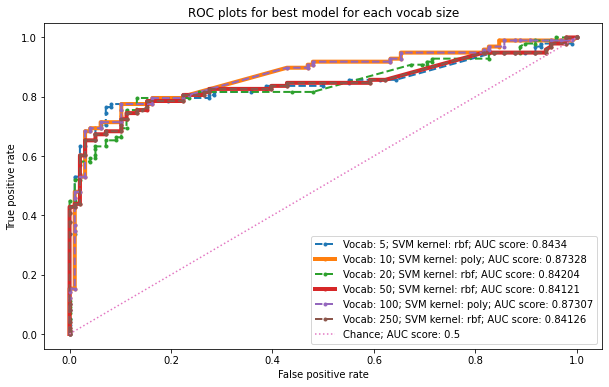

In [734]:
#create plot for just run SVM with those paramas, onces, no CV to get probabilities!
#this is using 100 vocab, which is index 1 in paths lists
train_image_feats = np.load(train_feat_paths[1])
test_image_feats = np.load(test_feat_paths[1])
vocab_sizes = [5,10,20,50,100,250]
Cs = [1.0, 1.0, 10.0, 10.0, 1.0, 10,0]
Ks = ["rbf", "poly", "rbf", "rbf", "poly", "rbf"]
Ds = [2,3,2,2,3,2]
Gs = [1.0, 1.0, 0.1, 1.0, 1.0, 1.0]
labels = ["Vocab: 5"]
roc_auc_scores = []
plt.rcParams['figure.figsize'] = (10, 6)


for i in np.arange(0,6):
    clf = SVC(C=Cs[i], kernel=Ks[i], degree=Ds[i], gamma=Gs[i], probability=True)
    clf.fit(train_image_feats, train_labels)
    #clf.predict(test_image_feats)
    probs = clf.predict_proba(test_image_feats)
    positive_class_probs = probs[:,1]
    roc_auc_scores.append(roc_auc_score(test_labels, positive_class_probs))
    ra_score = np.round( roc_auc_score(test_labels, positive_class_probs), 5)
    #in binary y_score shorld be 1D and give the probs of positive class
    #get false positive rate, true positive rate and thresholds
    fpr, tpr, thresholds = roc_curve(y_true=np.array(test_labels), y_score=positive_class_probs, pos_label="zx")
    #https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
    label="Vocab: "+str(vocab_sizes[i])+"; SVM kernel: "+Ks[i]+"; AUC score: "+str(ra_score)
    #vary linewidth to show overlappping plots
    if vocab_sizes[i]==10 or vocab_sizes[i]==50:
        lw = 4
        ls = '-'
    else:
        lw = 2
        ls = '--'
    plt.plot(fpr, tpr, label=label, marker='.', alpha=1, linestyle=ls, linewidth=lw)
    
plt.plot([0,1],[0,1], label='Chance; AUC score: 0.5', linestyle='dotted')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC plots for best model for each vocab size")
plt.legend()
plt.show()

In [700]:
roc_auc_scores
#chance roc auc score is 0.5

[0.8433985839233652,
 0.8732819658475635,
 0.842201166180758,
 0.8412640566430653,
 0.8732819658475635,
 0.8412119950020824]

In [710]:
np.round(roc_auc_scores[0], 2)

0.84

# Show examples of TP/TN/FP/FN images

- use best model: 100 vocab model

In [558]:
#predictions
v100_preds = bbss.best_prediction[4]
#use test_labels to describe as tp,fn,fp,tn
outcome=[]
for truth, pred in zip(test_labels, v100_preds):
    if truth == "zx" and pred == "zx":
        outcome.append("tp")
    elif truth == "zx" and pred == "nzx":
        outcome.append("fn")
    elif truth == "nzx" and pred == "zx":
        outcome.append("fp")
    elif truth == "nzx" and pred == "nzx":
        outcome.append("tn")
outcome=np.array(outcome)

/Users/tamsinforbes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


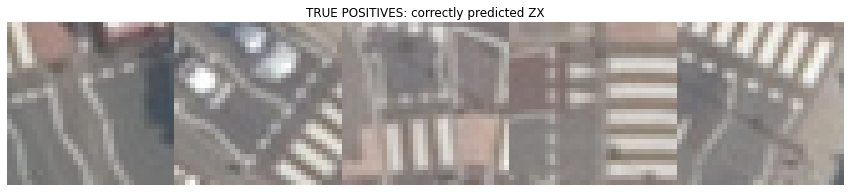

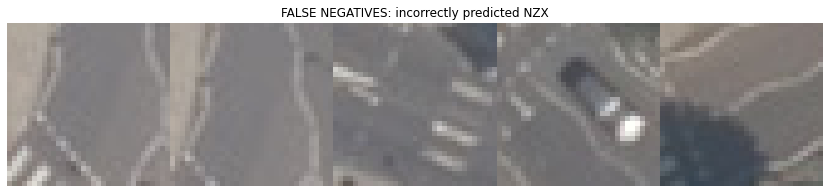

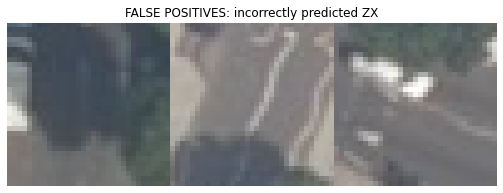

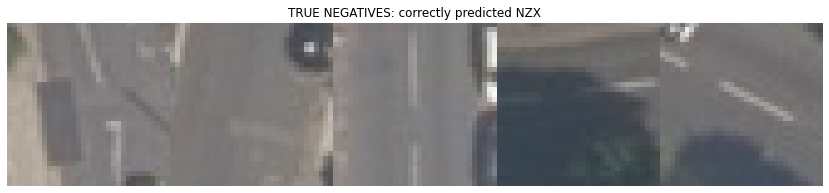

In [595]:
ex_titles = ["TRUE POSITIVES: correctly predicted ZX", "FALSE NEGATIVES: incorrectly predicted NZX"
             , "FALSE POSITIVES: incorrectly predicted ZX", "TRUE NEGATIVES: correctly predicted NZX"]
ex_abbr = ["tp", "fn", "fp", "tn"]
#np.random.seed(1234)
num_ims = 5

for x, t in zip(ex_abbr, ex_titles):
    ex_outcome = np.where(outcome==x)[0]
    if num_ims > len(ex_outcome):
        ids = np.random.choice(ex_outcome, len(ex_outcome), replace=False)
    else: ids = np.random.choice(ex_outcome, num_ims, replace=False)
        
    imgs = [ PIL.Image.open(test_image_paths[i]) for i in ids ]
    min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
    imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
    plt.imshow(imgs_comb)
    plt.title(t)
    plt.axis('off')
    plt.show()


/Users/tamsinforbes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


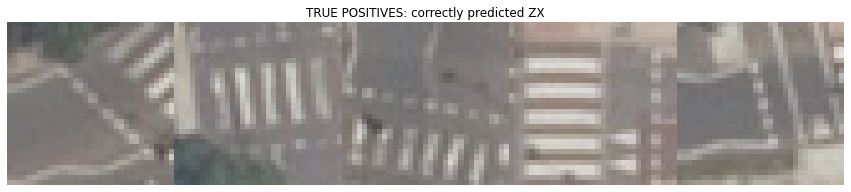

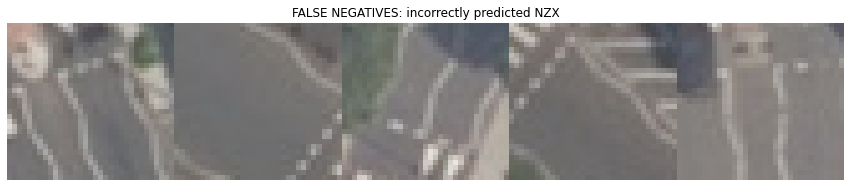

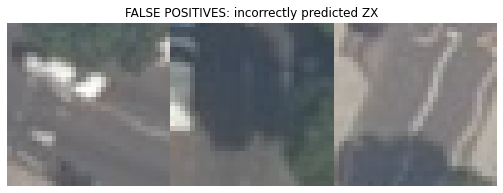

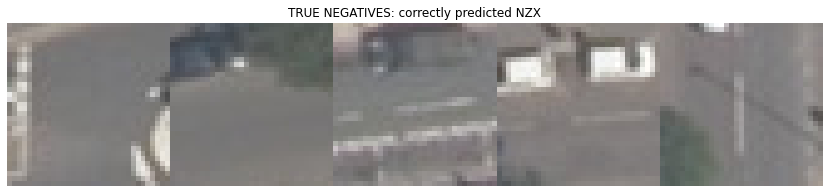

In [596]:
ex_titles = ["TRUE POSITIVES: correctly predicted ZX", "FALSE NEGATIVES: incorrectly predicted NZX"
             , "FALSE POSITIVES: incorrectly predicted ZX", "TRUE NEGATIVES: correctly predicted NZX"]
ex_abbr = ["tp", "fn", "fp", "tn"]
np.random.seed(1)
num_ims = 5

for x, t in zip(ex_abbr, ex_titles):
    ex_outcome = np.where(outcome==x)[0]
    if num_ims > len(ex_outcome):
        ids = np.random.choice(ex_outcome, len(ex_outcome), replace=False)
    else: ids = np.random.choice(ex_outcome, num_ims, replace=False)
        
    imgs = [ PIL.Image.open(test_image_paths[i]) for i in ids ]
    min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
    imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
    plt.imshow(imgs_comb)
    plt.title(t)
    plt.axis('off')
    plt.show()


/Users/tamsinforbes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


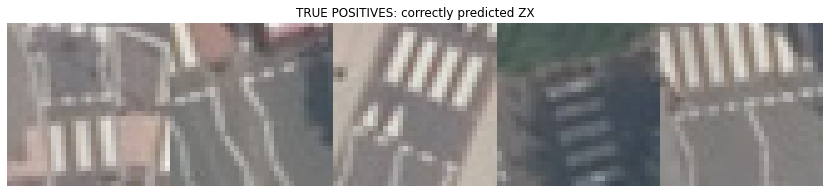

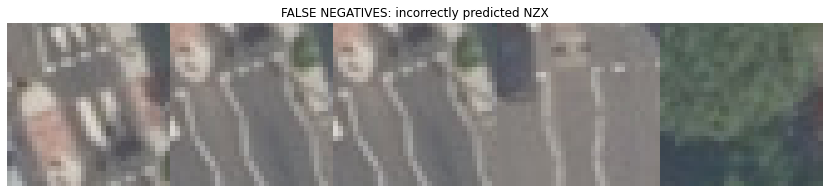

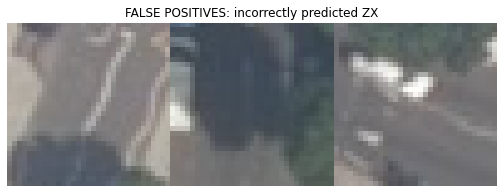

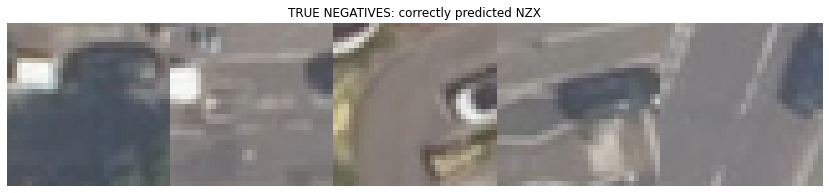

In [599]:
ex_titles = ["TRUE POSITIVES: correctly predicted ZX", "FALSE NEGATIVES: incorrectly predicted NZX"
             , "FALSE POSITIVES: incorrectly predicted ZX", "TRUE NEGATIVES: correctly predicted NZX"]
ex_abbr = ["tp", "fn", "fp", "tn"]
np.random.seed(4)
num_ims = 5

for x, t in zip(ex_abbr, ex_titles):
    ex_outcome = np.where(outcome==x)[0]
    if num_ims > len(ex_outcome):
        ids = np.random.choice(ex_outcome, len(ex_outcome), replace=False)
    else: ids = np.random.choice(ex_outcome, num_ims, replace=False)
        
    imgs = [ PIL.Image.open(test_image_paths[i]) for i in ids ]
    min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
    imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
    plt.imshow(imgs_comb)
    plt.title(t)
    plt.axis('off')
    plt.show()


/Users/tamsinforbes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


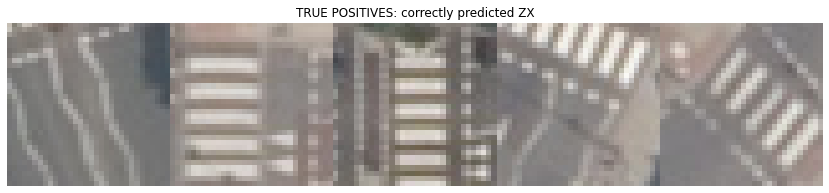

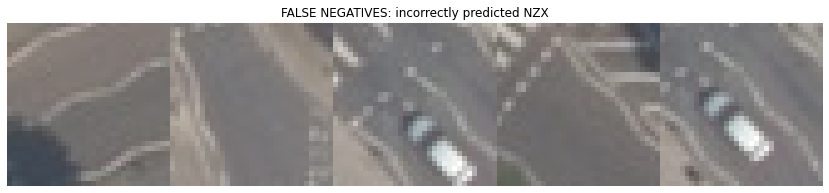

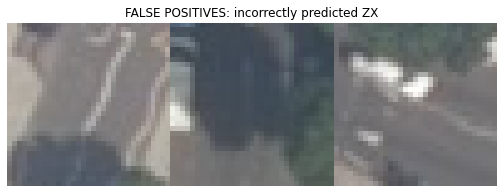

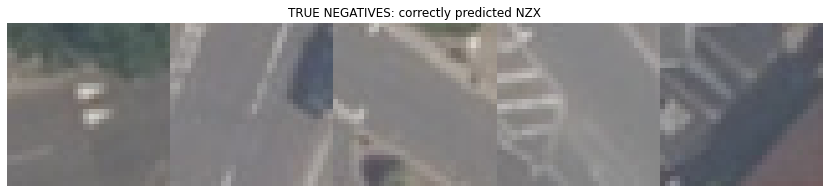

In [602]:
ex_titles = ["TRUE POSITIVES: correctly predicted ZX", "FALSE NEGATIVES: incorrectly predicted NZX"
             , "FALSE POSITIVES: incorrectly predicted ZX", "TRUE NEGATIVES: correctly predicted NZX"]
ex_abbr = ["tp", "fn", "fp", "tn"]
np.random.seed(7)
num_ims = 5

for x, t in zip(ex_abbr, ex_titles):
    ex_outcome = np.where(outcome==x)[0]
    if num_ims > len(ex_outcome):
        ids = np.random.choice(ex_outcome, len(ex_outcome), replace=False)
    else: ids = np.random.choice(ex_outcome, num_ims, replace=False)
        
    imgs = [ PIL.Image.open(test_image_paths[i]) for i in ids ]
    min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
    imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
    plt.imshow(imgs_comb)
    plt.title(t)
    plt.axis('off')
    plt.show()


/Users/tamsinforbes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


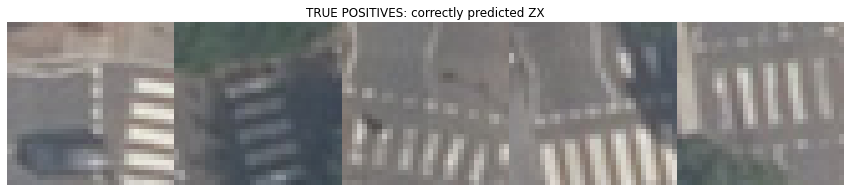

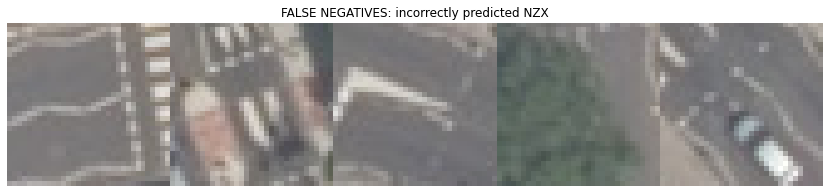

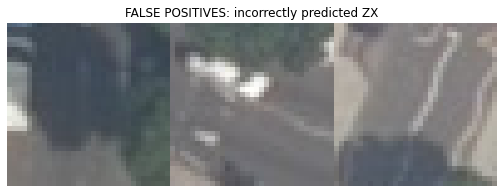

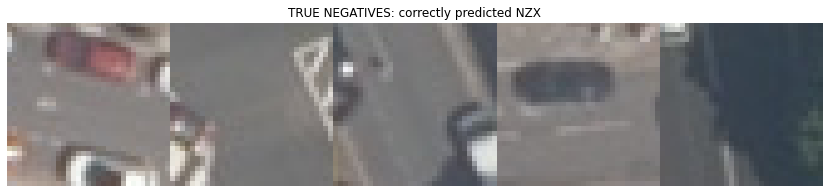

In [608]:
ex_titles = ["TRUE POSITIVES: correctly predicted ZX", "FALSE NEGATIVES: incorrectly predicted NZX"
             , "FALSE POSITIVES: incorrectly predicted ZX", "TRUE NEGATIVES: correctly predicted NZX"]
ex_abbr = ["tp", "fn", "fp", "tn"]
np.random.seed(13)
num_ims = 5

for x, t in zip(ex_abbr, ex_titles):
    ex_outcome = np.where(outcome==x)[0]
    if num_ims > len(ex_outcome):
        ids = np.random.choice(ex_outcome, len(ex_outcome), replace=False)
    else: ids = np.random.choice(ex_outcome, num_ims, replace=False)
        
    imgs = [ PIL.Image.open(test_image_paths[i]) for i in ids ]
    min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
    imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
    plt.imshow(imgs_comb)
    plt.title(t)
    plt.axis('off')
    plt.show()


/Users/tamsinforbes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


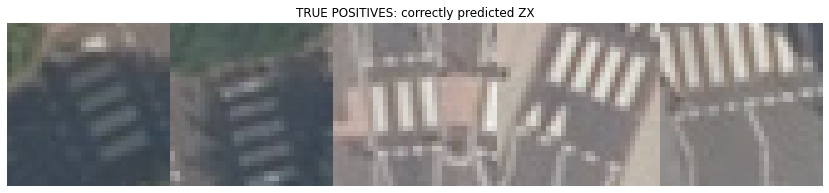

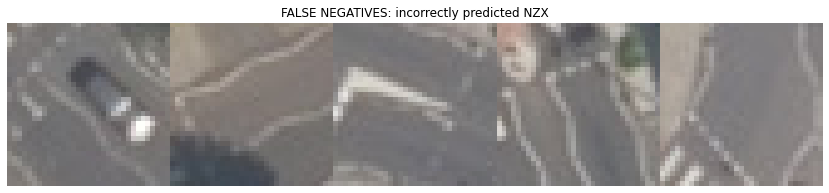

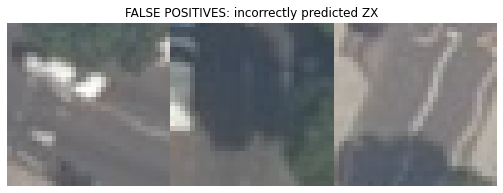

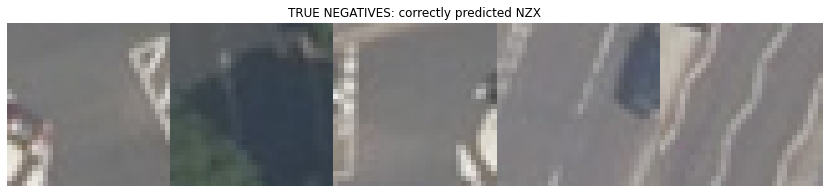

In [610]:
ex_titles = ["TRUE POSITIVES: correctly predicted ZX", "FALSE NEGATIVES: incorrectly predicted NZX"
             , "FALSE POSITIVES: incorrectly predicted ZX", "TRUE NEGATIVES: correctly predicted NZX"]
ex_abbr = ["tp", "fn", "fp", "tn"]
np.random.seed(14)
num_ims = 5

for x, t in zip(ex_abbr, ex_titles):
    ex_outcome = np.where(outcome==x)[0]
    if num_ims > len(ex_outcome):
        ids = np.random.choice(ex_outcome, len(ex_outcome), replace=False)
    else: ids = np.random.choice(ex_outcome, num_ims, replace=False)
        
    imgs = [ PIL.Image.open(test_image_paths[i]) for i in ids ]
    min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
    imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
    plt.imshow(imgs_comb)
    plt.title(t)
    plt.axis('off')
    plt.show()


# View some patches together

In [685]:
root="../data/road_patches/all_patches/"
grid="TQ1280"
ids=list(np.arange(1029,1041))

for i in ids:
    path = root+grid+"_"+str(i)+".tif"
    print(path)

../data/road_patches/all_patches/TQ1280_1029.tif
../data/road_patches/all_patches/TQ1280_1030.tif
../data/road_patches/all_patches/TQ1280_1031.tif
../data/road_patches/all_patches/TQ1280_1032.tif
../data/road_patches/all_patches/TQ1280_1033.tif
../data/road_patches/all_patches/TQ1280_1034.tif
../data/road_patches/all_patches/TQ1280_1035.tif
../data/road_patches/all_patches/TQ1280_1036.tif
../data/road_patches/all_patches/TQ1280_1037.tif
../data/road_patches/all_patches/TQ1280_1038.tif
../data/road_patches/all_patches/TQ1280_1039.tif
../data/road_patches/all_patches/TQ1280_1040.tif


In [ ]:
for i in ids:
    path = root+grid+"_"+str(i)+".tif"
    
    with rio.open(path) as src:
        rio.plot.show(src.read(), transform=src.transform)


/Users/tamsinforbes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if __name__ == '__main__':


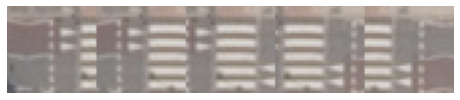

In [694]:
root="../data/road_patches/all_patches/"
grid="TQ1280"
#ids=list(np.arange(1030,1037))
ids=[1031, 1032, 1033,1034, 1035]

plt.rcParams['figure.figsize'] = (8, 6)      
imgs = [ PIL.Image.open(root+grid+"_"+str(i)+".tif") for i in ids ]
min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
plt.imshow(imgs_comb)
#plt.title("")
plt.axis('off')
plt.show()



# TO DO

# Show results

- confusion matrix, maybe try website builder thing ? 
- this will nicely show the TP/TN/FP/FN combinations can see which ones it got right/wrong and speculate why.

# Write up
- background stuff
- bit on isoperimetric quotient
- stuff: vocab, how it was built, how the images were collected etc...
- proof of concept
- is it overkill for 

# Put everything on github

# ARCHIVE

<AxesSubplot:>

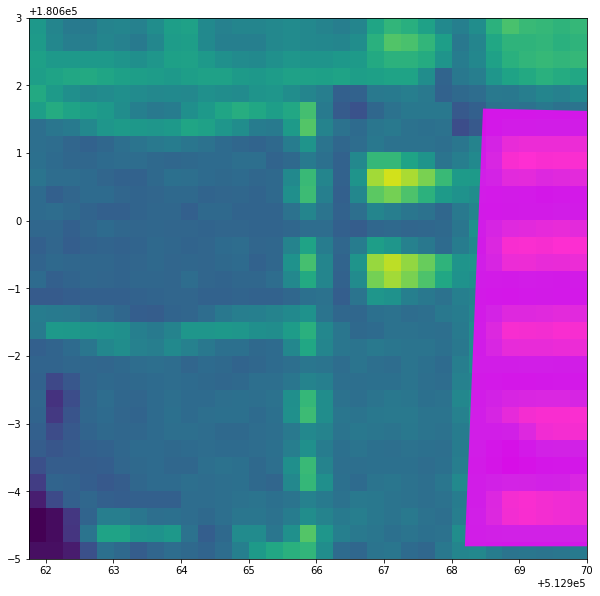

In [326]:
base = t2.plot(figsize=(10,10),color = 'magenta', alpha=0.8)
plot.show(src, ax = base) #uses rasterio plot module


# Describe patches

- use the vocab to create histograms that describe each patch
- I think I need to label which ones have zebra crossing in?
    - 126 to 129
    - 142 to 146
    - 265 to 269
- where no descriptors are found; this means the image is bland, so nothing to see, certainly no zebraX. Fine to ignore I think.
- but losing these from the array means I lose the order matching the image set and order

In [251]:
#create histogram features for training sets
for vp in vocab_paths:
    get_hist_feats(
        image_paths=road_patch_paths
        , vocab_path=vp
        , batch="x00", dir_path="../data/sift_kmeans/hist_feats/test")

Loaded vocab from file:../data/sift_kmeans/vocab/vocab_100.npy
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_117.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_118.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_119.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_120.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_121.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for

No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_236.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_244.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_252.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_271.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_272.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_273.t

No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_165.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_166.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_167.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_168.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_179.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_180.t

No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_130.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_165.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_166.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_167.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_168.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_179.t

In [252]:
v5 = get_hist_feats(
        image_paths=road_patch_paths
        , vocab_path=vocab_paths[2]
        , batch="x00", dir_path="../data/sift_kmeans/hist_feats/test")

Loaded vocab from file:../data/sift_kmeans/vocab/vocab_5.npy
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_117.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_118.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_119.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_120.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for image at path:
../data/road_patches/set_01_TQ2079/TQ2079_121.tif
Warning if using in train stage remove this image
else appending 0 row histogram feature
No descriptors returned for i

In [254]:
print(len(v5))
v5

197


array([[0.19245009, 0.76980036, 0.57735027, 0.        , 0.19245009],
       [0.13608276, 0.81649658, 0.54433105, 0.        , 0.13608276],
       [0.        , 0.80178373, 0.53452248, 0.        , 0.26726124],
       [0.        , 0.87006284, 0.48336824, 0.        , 0.09667365],
       [0.        , 0.66666667, 0.66666667, 0.        , 0.33333333],
       [0.        , 0.70710678, 0.70710678, 0.        , 0.        ],
       [0.        , 0.89442719, 0.4472136 , 0.        , 0.        ],
       [0.        , 0.89442719, 0.4472136 , 0.        , 0.        ],
       [0.        , 0.89442719, 0.4472136 , 0.        , 0.        ],
       [0.        , 0.5547002 , 0.83205029, 0.        , 0.        ],
       [0.        , 0.81649658, 0.40824829, 0.        , 0.40824829],
       [0.        , 0.48154341, 0.84270097, 0.        , 0.24077171],
       [0.        , 0.59628479, 0.74535599, 0.        , 0.2981424 ],
       [0.        , 0.43643578, 0.87287156, 0.        , 0.21821789],
       [0.        , 0.4472136 , 0.

- I think I need to label which ones have zebra crossing in?
    - 126 to 129
    - 142 to 146
    - 265 to 269

In [257]:
np.arange(265,270)

array([265, 266, 267, 268, 269])

In [260]:
zebra_ids=[126, 127, 128, 129,142, 143, 144, 145, 146, 265, 266, 267, 268, 269]
len(zebra_ids)

14

# Isolated zebras with sobel filters

The false edge created by the no data fill outside the zebra polygon is problematic as this is the most distinct edge in the image. Use bounding box containing zebra crossings to remove this and provide context for the zebra crossing.

maximum of angles: 3.141592653589793, minimum of angles: -3.1204987363362386, maximum of magnitudes: 742.9468352446223, minimum of magnitudes: 0.0


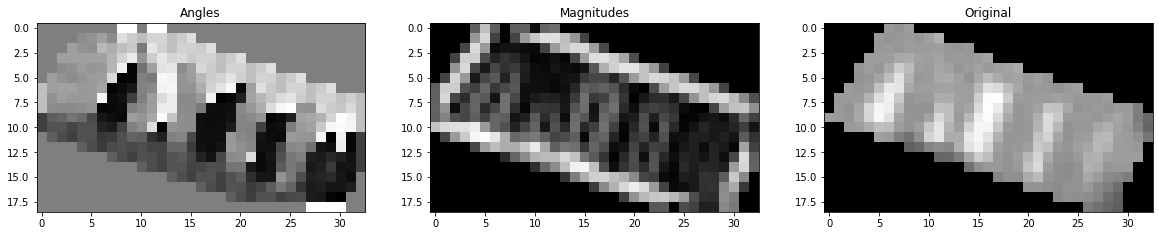

In [23]:
# get sobel filters
I_x = cv2.Sobel(grey_im, cv2.CV_64F, 1, 0, ksize=3)
I_y = cv2.Sobel(grey_im, cv2.CV_64F, 0, 1, ksize=3)

# compute angles and magnitudes of the image
angles = np.arctan2(I_y, I_x)
magnitudes = np.sqrt(I_x ** 2 + I_y ** 2)

print('maximum of angles: {0}, minimum of angles: {1}, maximum of magnitudes: {2}, minimum of magnitudes: {3}'
.format(np.max(angles), np.min(angles), np.max(magnitudes), np.min(magnitudes)))

plt.rcParams['figure.figsize'] = (20.0, 10.0)

# plot
plt.subplot(1, 3, 1); plt.imshow(angles, cmap='gray')
plt.title('Angles')
plt.subplot(1, 3, 2); plt.imshow(magnitudes, cmap='gray')
plt.title('Magnitudes')
plt.subplot(1, 3, 3); plt.imshow(grey_im, cmap='gray')
plt.title('Original')
plt.show()

# Some zebras with sobel filters

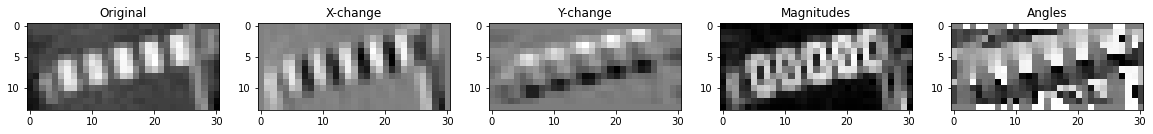

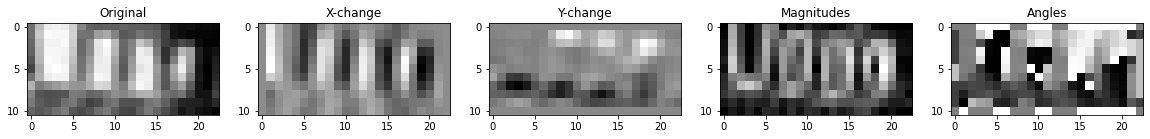

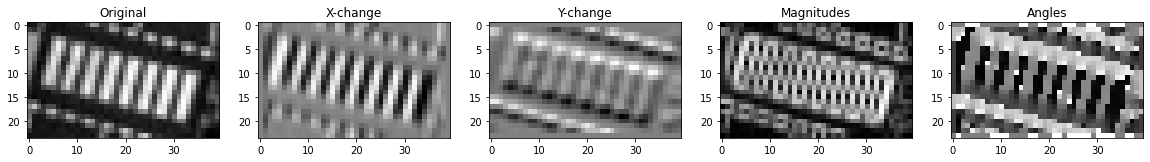

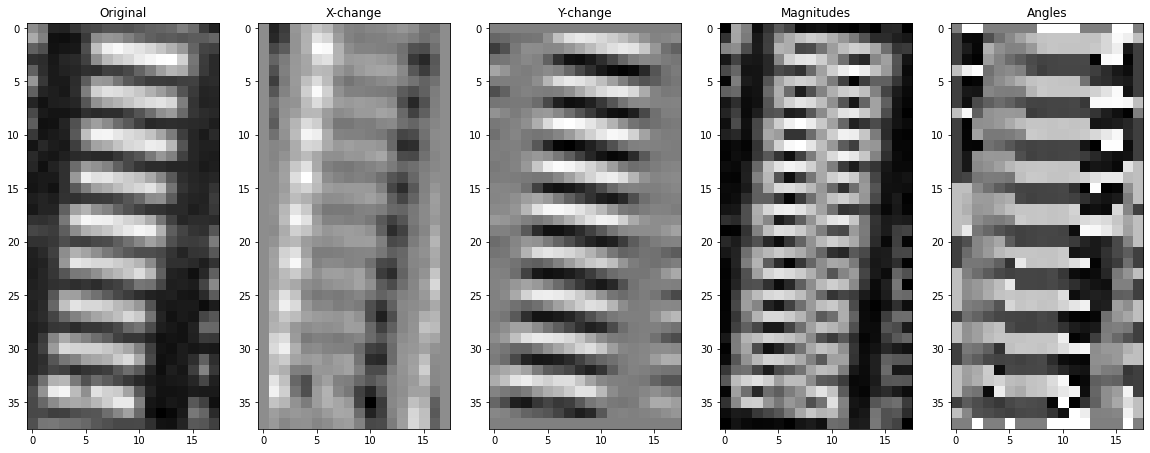

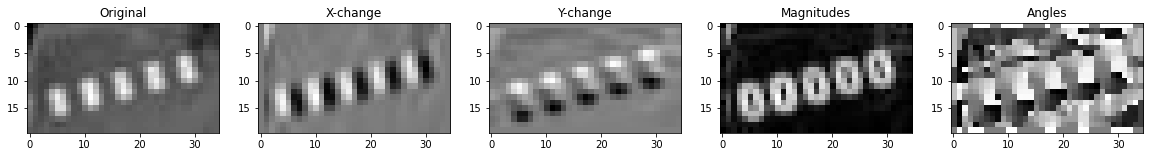

In [69]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

for path in zebra_bbox_paths[15:20]:
    im = cv2.imread(path)
    grey_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    grey_im = np.float32(grey_im)
    # get sobel filters
    I_x = cv2.Sobel(grey_im, cv2.CV_64F, 1, 0, ksize=3)
    I_y = cv2.Sobel(grey_im, cv2.CV_64F, 0, 1, ksize=3)
    # compute angles and magnitudes of the image
    angles = np.arctan2(I_y, I_x)
    magnitudes = np.sqrt(I_x ** 2 + I_y ** 2)
    # plot
    plt.subplot(1, 5, 1); plt.imshow(grey_im, cmap='gray')
    plt.title('Original')
    plt.subplot(1, 5, 2); plt.imshow(I_x, cmap='gray')
    plt.title('X-change')
    plt.subplot(1, 5, 3); plt.imshow(I_y, cmap='gray')
    plt.title('Y-change')
    plt.subplot(1, 5, 4); plt.imshow(magnitudes, cmap='gray')
    plt.title('Magnitudes')
    plt.subplot(1, 5, 5); plt.imshow(angles, cmap='gray')
    plt.title('Angles')

    plt.show()

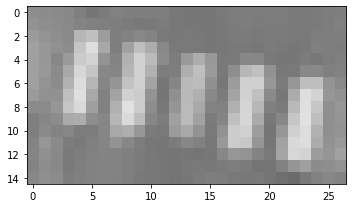

In [61]:
path = zebra_bbox_paths[1]
plt.rcParams['figure.figsize'] = (6.0, 3.0)
im = skimage.io.imread(path, as_gray=True)
skimage.io.imshow(im)

In [63]:
grey_im.shape

(20, 40)

In [62]:
sigma=1.6
contrastThreshold=0.04
#compute sift descriptor
sift = cv2.SIFT_create(sigma=sigma, contrastThreshold=contrastThreshold)
#computes keypoints and corresponding descriptors
kps, des = sift.detectAndCompute(grey_im, None)


error: OpenCV(4.4.0) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-48c801ya/opencv/modules/features2d/src/sift.dispatch.cpp:465: error: (-5:Bad argument) image is empty or has incorrect depth (!=CV_8U) in function 'detectAndCompute'


# next step

- BoVW model? edge model? CNN?
- work out how to progress a window along only the roads in an image file
- or take an image file and create a set of window patches that will be checked for zebras
- I need to know which of these patches contain a zebra?
- go through list of window patches creating descriptor for that patch
- compare this descriptor to the BoVW descriptor for zebras
- split the zebra images into test and train

In [54]:
#read in zebra polygon shapfile this is in 4326
#zp = gpd.read_file("../data/zebra_locations_ealing82/zebra_polygons.shp")

In [56]:
zp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [83]:
zp.tail()

,id,geometry
364,267,"MULTIPOLYGON (((516428.680 181618.711, 516437...."
365,923,"MULTIPOLYGON (((519581.281 181856.359, 519588...."
366,148,"MULTIPOLYGON (((520598.419 180313.075, 520601...."
367,149,"MULTIPOLYGON (((520752.212 180347.170, 520756...."
368,160,"MULTIPOLYGON (((520552.396 179251.828, 520559...."


In [60]:
zp.head()

,id,geometry
0,367,"MULTIPOLYGON (((512437.882 185793.856, 512441...."
1,249,"MULTIPOLYGON (((516677.944 185718.567, 516680...."
2,250,"MULTIPOLYGON (((516683.339 185720.815, 516686...."
3,251,"MULTIPOLYGON (((516768.828 185515.308, 516774...."
4,252,"MULTIPOLYGON (((516736.998 185482.967, 516740...."


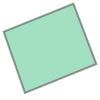

In [66]:
zp.geometry.iloc[1]